# Quantisierung erklärt — Von FP64 bis INT4

Dieses Notebook zeigt anschaulich, was bei der **Quantisierung** von Modellgewichten passiert:
- Wie sehen Zahlen in verschiedenen Floating-Point-Formaten aus?
- Was wird bei niedrigerer Präzision **abgeschnitten**?
- Wie viel **Speicher** spart man konkret?
- Was passiert mit einem ganzen **Embedding-Vektor** (z.b. 64D)?

---

### Inhaltsverzeichnis

1. [Was ist Quantisierung?](#sec-intro)
2. [Floating-Point Grundlagen (IEEE 754)](#sec-ieee754)
3. [Praktisches Beispiel: Einzelne Floats](#sec-single-floats)
4. [Praktisches Beispiel: 64D Embedding-Vektor](#sec-vector64)
5. [Integer-Quantisierung (INT8, INT4)](#sec-integer-quant)
6. [Block-Quantisierung und GGUF](#sec-block-quant)
7. [Speichereinsparung in der Praxis](#sec-memory)
8. [Qualitätsvergleich: Alle Formate](#sec-quality)
9. [Zusammenfassung und Empfehlungen](#sec-summary)

In [126]:
import struct
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, HTML

plt.style.use('dark_background')
plt.rcParams.update({'axes.grid': True, 'grid.alpha': 0.3})

<a id="sec-intro"></a>

## 1. Was ist Quantisierung?

**Quantisierung** bedeutet, Zahlen mit **weniger Bits** darzustellen. Ein neuronales Netz speichert seine Gewichte typischerweise als 32-Bit Floating-Point-Zahlen (FP32). Das sind **4 Bytes pro Gewicht**.

Ein Modell wie Qwen3-8B hat **8 Milliarden** Gewichte. Der Speicherbedarf berechnet sich aus:

$$\text{Speicher} = \text{Parameter} \times \frac{\text{Bits}}{8} = \text{Parameter} \times \text{Bytes pro Gewicht}$$

Für Qwen3-8B in FP16 (2 Byte pro Parameter) ergibt das (vgl. [LORA_EXPLAINED.md](../languageModel/docs/LORA_EXPLAINED.md)):

$$8 \times 10^9 \;\text{Parameter} \times 2 \;\text{Byte} = 16 \;\text{GB}$$

| Format | Bits | Bytes pro Gewicht | Gesamtgröße (8B Modell) |
|--------|------|-------------------|-------------------------|
| FP32   | 32   | 4                 | **~32 GB**              |
| FP16   | 16   | 2                 | **~16 GB**              |
| INT8   | 8    | 1                 | **~8 GB**               |
| INT4   | 4    | 0.5               | **~4 GB**               |

*(Vereinfachte Werte ohne Block-Overhead — die exakten Größen inkl. Scale-Factor-Overhead berechnen wir in [Kapitel 7](#sec-memory).)*

Die zentrale Frage: **Wie viel Qualität verliert man dabei?**

Aber wie werden Zahlen überhaupt im Computer gespeichert? Um zu verstehen, was beim Quantisieren verloren geht, müssen wir zuerst die Floating-Point-Darstellung nach IEEE 754 verstehen.

<a id="sec-ieee754"></a>

## 2. Floating-Point Grundlagen (IEEE 754)

Jede Floating-Point-Zahl besteht aus drei Teilen:

$$(-1)^{\text{sign}} \times 2^{\text{exponent} - \text{bias}} \times (1 + \text{mantissa})$$

| Format | Sign | Exponent | Mantissa | Total Bits | Dezimalstellen | Bereich |
|--------|------|----------|----------|------------|----------------|------------------|
| FP64   | 1    | 11       | 52       | 64         | ~15-17         | $\pm 1.8 \times 10^{308}$ |
| FP32   | 1    | 8        | 23       | 32         | ~6-9           | $\pm 3.4 \times 10^{38}$* |
| FP16   | 1    | 5        | 10       | 16         | ~3-4           | $\pm 6.5 \times 10^{4}$ |
| BF16   | 1    | **8**    | 7        | 16         | ~2-3           | $\pm 3.4 \times 10^{38}$* |

*\* Gleicher Bereich, weil gleiche Anzahl Exponent-Bits (8).*

**Wichtig:** Der **Wertebereich** wird durch die **Exponent-Bits** bestimmt, die **Präzision** (Dezimalstellen) durch die **Mantissa-Bits**. Deshalb hat BF16 trotz nur 16 Bit den gleichen Bereich wie FP32 — beide haben **8 Exponent-Bits**. FP16 dagegen hat nur 5 Exponent-Bits und kommt daher nur bis $\pm 6.5 \times 10^4$.

**BF16 (Brain Float 16)** kürzt die Mantissa von FP32 (23 → 7 Bits) und behält den Exponenten (8 Bits) bei. Entwickelt von Google Brain speziell für Deep Learning: Gradienten können während des Trainings extreme Werte annehmen (z.B. bei Gradient Spikes), weshalb der große Wertebereich wichtiger ist als hohe Präzision der einzelnen Gewichte.

Was passiert nun mit konkreten Zahlen, wenn wir sie in diese Formate umwandeln?

In [127]:
# ============================================================
# Hilfsfunktionen: Binärdarstellung von Floats
# ============================================================

def float_to_binary(value, fmt):
    """Wandelt einen Float in seine Binärdarstellung um.
    
    Args:
        value: Die Zahl
        fmt: 'fp64', 'fp32', 'fp16', 'bf16'
    
    Returns:
        Tuple: (sign_bits, exponent_bits, mantissa_bits, reconstructed_value)
    """
    if fmt == 'fp64':
        packed = struct.pack('>d', value)
        bits = ''.join(f'{b:08b}' for b in packed)
        return bits[0], bits[1:12], bits[12:], value
    
    elif fmt == 'fp32':
        val_fp32 = np.float32(value)
        packed = struct.pack('>f', val_fp32)
        bits = ''.join(f'{b:08b}' for b in packed)
        return bits[0], bits[1:9], bits[9:], float(val_fp32)
    
    elif fmt == 'fp16':
        val_fp16 = np.float16(value)
        packed = np.float16(value).tobytes()
        # Little-endian -> Big-endian
        bits = ''.join(f'{b:08b}' for b in reversed(packed))
        return bits[0], bits[1:6], bits[6:], float(val_fp16)
    
    elif fmt == 'bf16':
        # BF16 = obere 16 Bits von FP32
        val_fp32 = np.float32(value)
        packed = struct.pack('>f', val_fp32)
        all_bits = ''.join(f'{b:08b}' for b in packed)
        bf16_bits = all_bits[:16]  # Obere 16 Bits
        # Rekonstruktion: untere 16 Bits auf 0 setzen
        bf16_bytes = int(all_bits[:16] + '0' * 16, 2).to_bytes(4, 'big')
        reconstructed = struct.unpack('>f', bf16_bytes)[0]
        return bf16_bits[0], bf16_bits[1:9], bf16_bits[9:], reconstructed


def format_info(fmt):
    """Gibt Metadaten zu einem Float-Format zurück."""
    info = {
        'fp64': {'name': 'FP64 (Double)', 'bits': 64, 'bytes': 8, 'color': '#3498db',
                 'exp_bits': 11, 'mant_bits': 52},
        'fp32': {'name': 'FP32 (Float)',  'bits': 32, 'bytes': 4, 'color': '#2ecc71',
                 'exp_bits': 8,  'mant_bits': 23},
        'fp16': {'name': 'FP16 (Half)',   'bits': 16, 'bytes': 2, 'color': '#e67e22',
                 'exp_bits': 5,  'mant_bits': 10},
        'bf16': {'name': 'BF16 (BFloat)', 'bits': 16, 'bytes': 2, 'color': '#e74c3c',
                 'exp_bits': 8,  'mant_bits': 7},
    }
    return info[fmt]


<a id="sec-single-floats"></a>

## 3. Praktisches Beispiel: Einzelne Floats

Jedes Format hat eine unterschiedliche Anzahl an **Mantissa-Bits** — das bestimmt, wie viele Dezimalstellen erhalten bleiben.

Zunächst ein bekanntes Beispiel, das zeigt, warum Floating-Point-Arithmetik selbst bei "normalen" Zahlen tückisch ist:

In [128]:
# Das berühmteste Beispiel der Informatik:
a, b = 0.1, 0.2
result = a + b

# Warum? Weil 0.1 im Binärsystem eine *periodische* Zahl ist:
#   0.1 (dezimal) = 0.0001100110011001100... (binär, periodisch!)
# Das ist wie 1/3 = 0.3333... im Dezimalsystem — es hört nie auf.
# Der Computer muss irgendwann abschneiden → es entsteht ein Rundungsfehler.

rows = []
for fmt in ['fp64', 'fp32', 'fp16', 'bf16']:
    info = format_info(fmt)
    _, _, _, v01 = float_to_binary(0.1, fmt)
    _, _, _, v02 = float_to_binary(0.2, fmt)

    if fmt == 'fp64':
        s = v01 + v02
    elif fmt == 'fp32':
        s = float(np.float32(v01) + np.float32(v02))
    elif fmt == 'fp16':
        s = float(np.float16(v01) + np.float16(v02))
    else:
        def to_bf16(x):
            f32 = np.float32(x)
            return struct.unpack('>f', (struct.pack('>f', f32)[0:2] + b'\x00\x00'))[0]
        s = to_bf16(to_bf16(0.1) + to_bf16(0.2))

    rows.append({
        '0.1':       f'{v01:.20g}',
        '0.2':       f'{v02:.20g}',
        '0.1 + 0.2': f'{s:.20g}',
        'Fehler zu 0.3': f'{abs(s - 0.3):.2e}',
    })

df_01 = pd.DataFrame(rows, index=[format_info(f)['name'] for f in ['fp64', 'fp32', 'fp16', 'bf16']])
display(df_01)

,0.1,0.2,0.1 + 0.2,Fehler zu 0.3
FP64 (Double),0.10000000000000000555,0.2000000000000000111,0.30000000000000004441,5.55e-17
FP32 (Float),0.10000000149011611938,0.20000000298023223877,0.30000001192092895508,1.19e-08
FP16 (Half),0.0999755859375,0.199951171875,0.2998046875,1.95e-04
BF16 (BFloat),0.099609375,0.19921875,0.298828125,1.17e-03


**Ergebnis:** `0.1 + 0.2` ist in **keinem** Floating-Point-Format exakt `0.3`. Das liegt daran, dass `0.1` im Binärsystem periodisch ist (wie 1/3 im Dezimalsystem). Je weniger Mantissa-Bits ein Format hat, desto größer wird der Rundungsfehler — BF16 mit nur 7 Mantissa-Bits hat den größten Fehler.

Jetzt zu zwei Beispielwerten, an denen sich die Unterschiede zwischen den Formaten gut zeigen lassen:
- **$\pi = 3.14159265...$** — eine typische Konstante
- **$1/3 = 0.33333333...$** — hier wird der Unterschied zwischen FP16 und BF16 besonders deutlich

In [129]:
pi = math.pi
one_third = 1.0 / 3.0

formats = ['fp64', 'fp32', 'fp16', 'bf16']

def count_matching_digits(ref_str, val_str):
    """Zählt übereinstimmende Zeichen von links."""
    match = 0
    for c1, c2 in zip(ref_str, val_str):
        if c1 == c2:
            match += 1
        else:
            break
    return match

# Ergebnisse für beide Beispielwerte sammeln
results = {}
results2 = {}
for fmt in formats:
    sign, exp, mant, val = float_to_binary(pi, fmt)
    info = format_info(fmt)
    results[fmt] = {'value': val, 'error': abs(pi - val), 'sign': sign, 'exp': exp, 'mant': mant}

    _, _, _, val2 = float_to_binary(one_third, fmt)
    results2[fmt] = {'value': val2, 'error': abs(one_third - val2)}

# Tabelle: Beide Beispielwerte in allen Formaten
fmt_names = [format_info(f)['name'] for f in formats]
bits_list = [format_info(f)['bits'] for f in formats]
bytes_list = [format_info(f)['bytes'] for f in formats]

df_pi = pd.DataFrame({
    'Bits':        bits_list,
    'Bytes':       bytes_list,
    'π Wert':      [f"{results[f]['value']:.15f}" for f in formats],
    'π Fehler':    [f"{results[f]['error']:.2e}" for f in formats],
    '1/3 Wert':    [f"{results2[f]['value']:.15f}" for f in formats],
    '1/3 Fehler':  [f"{results2[f]['error']:.2e}" for f in formats],
}, index=fmt_names)

display(df_pi)

# Matching-Digits Analyse
pi_ref = f"{pi:.15f}"
third_ref = f"{one_third:.15f}"
rows = []
for fmt in formats:
    info = format_info(fmt)
    pi_match = max(0, count_matching_digits(pi_ref, f"{results[fmt]['value']:.15f}") - 2)
    third_match = max(0, count_matching_digits(third_ref, f"{results2[fmt]['value']:.15f}") - 2)
    rows.append({'π': f'{pi_match} Stellen', '1/3': f'{third_match} Stellen'})

df_digits = pd.DataFrame(rows, index=[format_info(f)['name'] for f in formats])
display(df_digits)

,Bits,Bytes,π Wert,π Fehler,1/3 Wert,1/3 Fehler
FP64 (Double),64,8,3.141592653589793,0.00e+00,0.333333333333333,0.00e+00
FP32 (Float),32,4,3.141592741012573,8.74e-08,0.333333343267441,9.93e-09
FP16 (Half),16,2,3.140625000000000,9.68e-04,0.333251953125000,8.14e-05
BF16 (BFloat),16,2,3.140625000000000,9.68e-04,0.332031250000000,1.30e-03


,π,1/3
FP64 (Double),15 Stellen,15 Stellen
FP32 (Float),6 Stellen,7 Stellen
FP16 (Half),2 Stellen,3 Stellen
BF16 (BFloat),2 Stellen,2 Stellen


Für π liefern FP16 und BF16 zufällig den gleichen Wert, weil die drei zusätzlichen Mantissa-Bits von FP16 (Bit 8, 9, 10) bei π alle `0` sind — die Rundung ergibt daher dasselbe Ergebnis.

Bei 1/3 zeigt sich der echte Unterschied: Der BF16-Fehler ist ca. 8× größer als der FP16-Fehler, weil BF16 nur 7 statt 10 Mantissa-Bits hat.

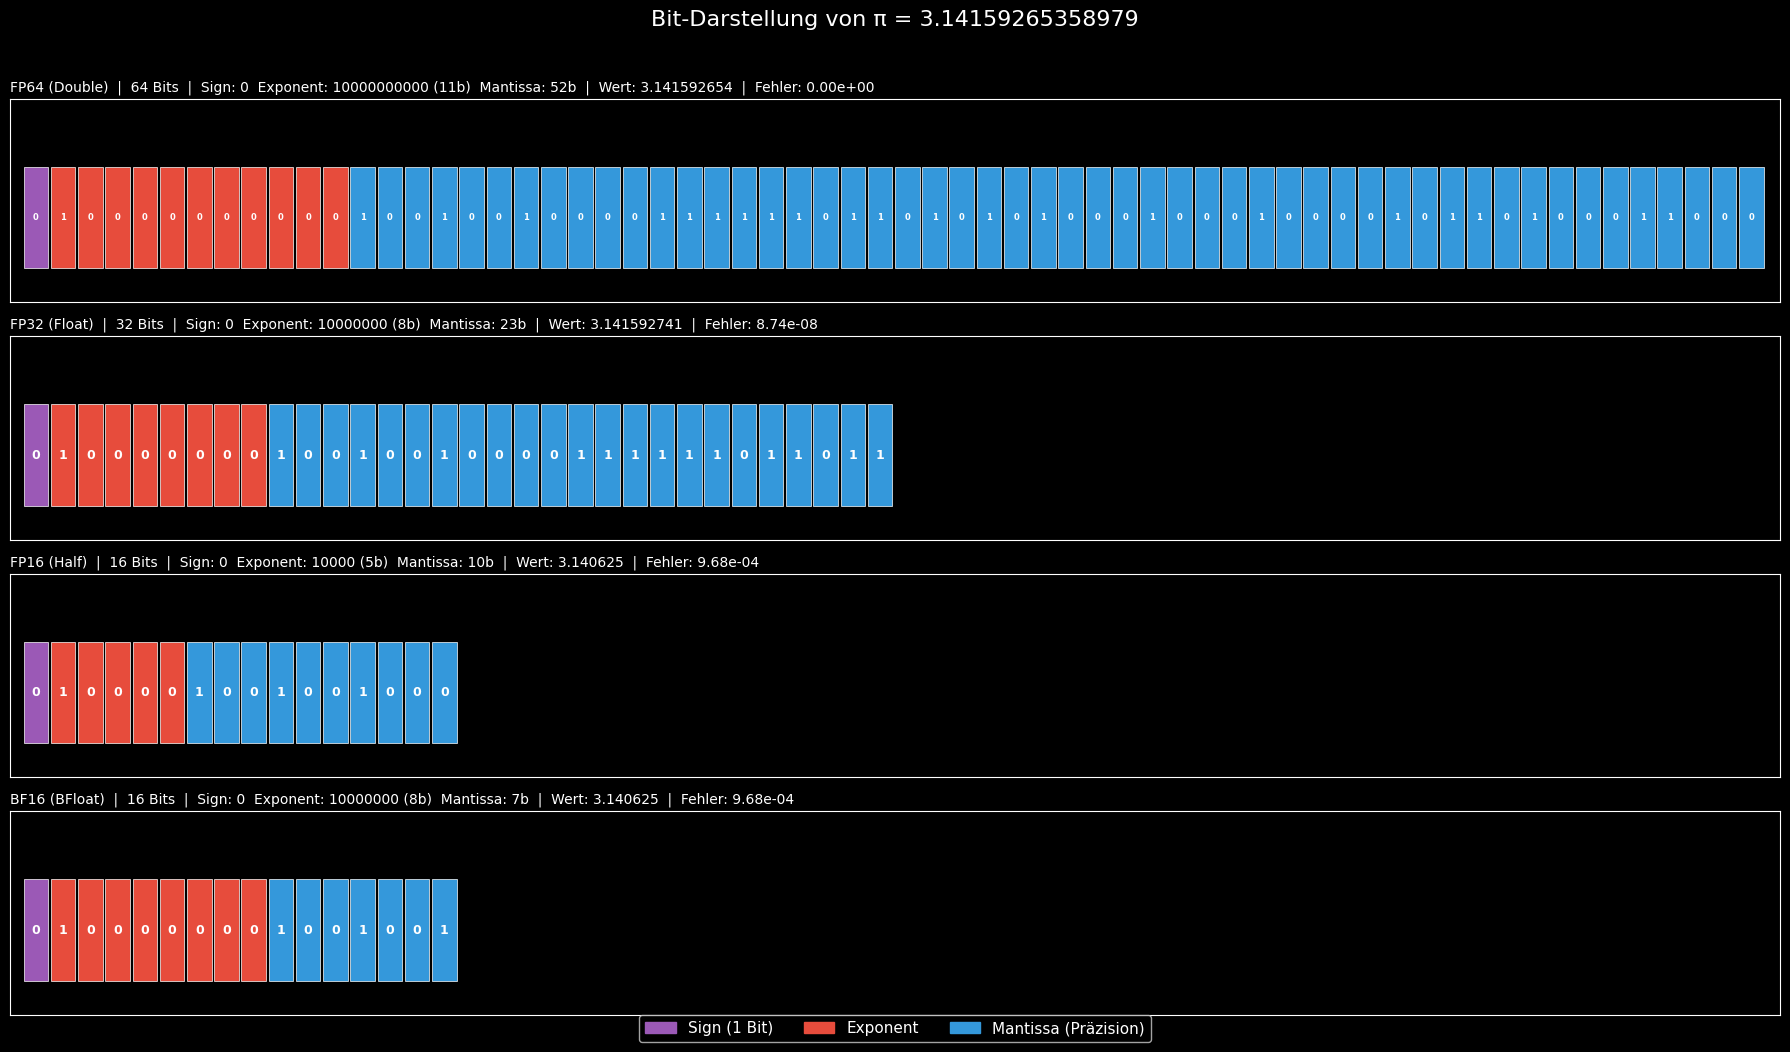

In [130]:
# ============================================================
# Visualisierung: Bit-Layout von Pi in jedem Format
# ============================================================

fig, axes = plt.subplots(len(formats), 1, figsize=(18, 10))
fig.suptitle(f'Bit-Darstellung von \u03c0 = {pi:.15g}', fontsize=16, y=1.02)

for ax, fmt in zip(axes, formats):
    info = format_info(fmt)
    sign, exp, mant, val = results[fmt]['sign'], results[fmt]['exp'], results[fmt]['mant'], results[fmt]['value']
    error = results[fmt]['error']
    
    all_bits = sign + exp + mant
    total = len(all_bits)
    
    # Bit-Boxen zeichnen
    for i, bit in enumerate(all_bits):
        if i == 0:
            color = '#9b59b6'  # Sign: Lila
        elif i <= info['exp_bits']:
            color = '#e74c3c'  # Exponent: Rot
        else:
            color = '#3498db'  # Mantissa: Blau
        
        rect = plt.Rectangle((i, 0), 0.9, 0.9, facecolor=color, edgecolor='white', linewidth=0.5)
        ax.add_patch(rect)
        fontsize = 9 if total <= 32 else 6 if total <= 64 else 5
        ax.text(i + 0.45, 0.45, bit, ha='center', va='center', fontsize=fontsize,
                color='white', fontweight='bold')
    
    ax.set_xlim(-0.5, max(total, 64) + 0.5)
    ax.set_ylim(-0.3, 1.5)
    ax.set_yticks([])
    ax.set_xticks([])
    
    # Label mit Wert und Fehler
    ax.set_title(
        f"{info['name']}  |  {total} Bits  |  "
        f"Sign: {sign}  Exponent: {exp} ({info['exp_bits']}b)  Mantissa: {len(mant)}b  |  "
        f"Wert: {val:.10g}  |  Fehler: {error:.2e}",
        fontsize=10, loc='left'
    )

# Legende
legend_patches = [
    mpatches.Patch(color='#9b59b6', label='Sign (1 Bit)'),
    mpatches.Patch(color='#e74c3c', label='Exponent'),
    mpatches.Patch(color='#3498db', label='Mantissa (Pr\u00e4zision)'),
]
fig.legend(handles=legend_patches, loc='lower center', ncol=3, fontsize=11,
           bbox_to_anchor=(0.5, -0.02))

plt.tight_layout()
plt.show()

Die Farbcodierung zeigt die drei Bestandteile: **Sign** (lila, 1 Bit), **Exponent** (rot) und **Mantissa** (blau). Man sieht direkt: FP64 hat 52 blaue Mantissa-Bits, BF16 nur 7. Je weniger Mantissa-Bits, desto früher wird die Binärdarstellung abgeschnitten — und desto größer wird der Rundungsfehler.

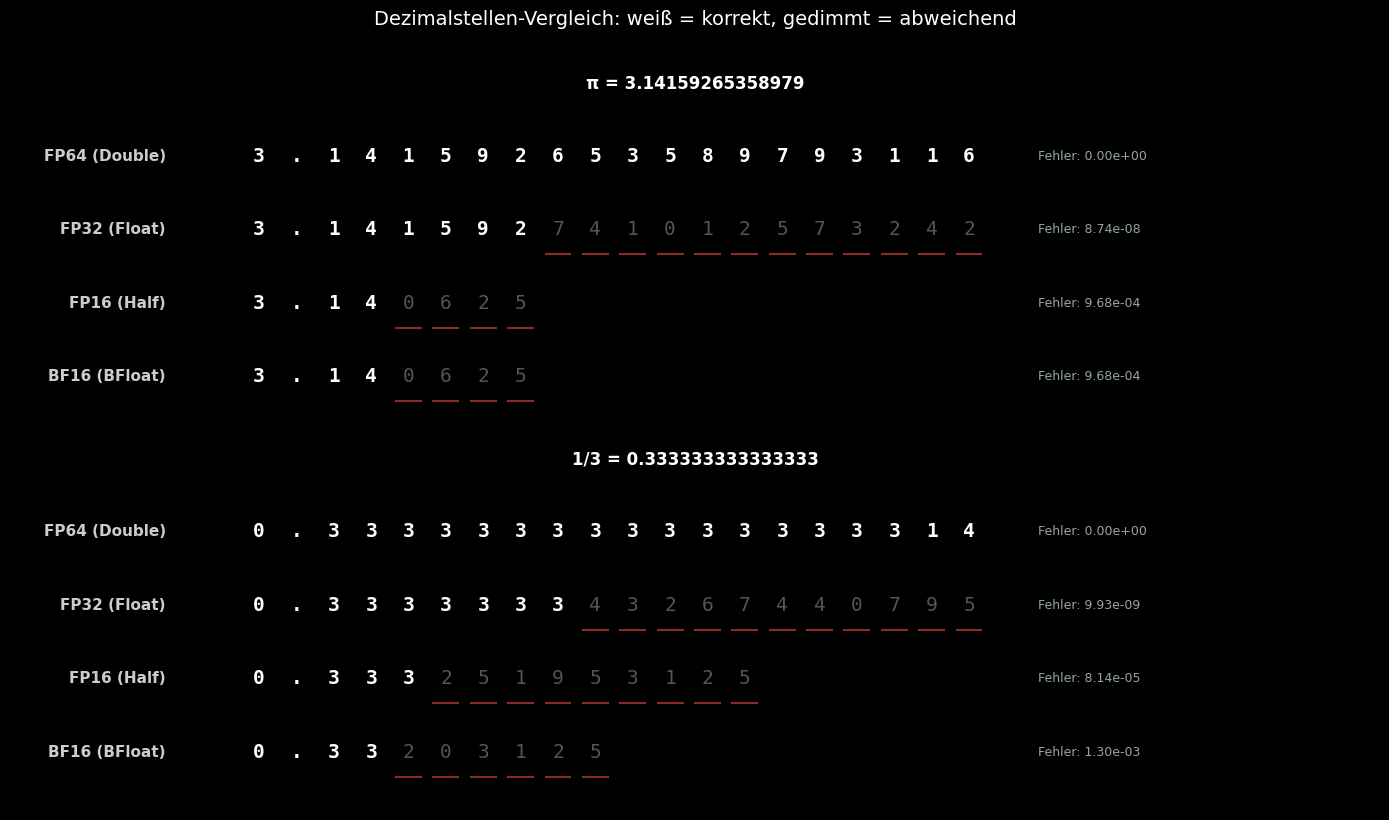

In [131]:
# ============================================================
# Vergleich: Welche Dezimalstellen bleiben erhalten?
# ============================================================

fig, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(14, 8))

for ax, ref_val, ref_name, res_dict in [
    (ax_top, pi, "π", results),
    (ax_bot, one_third, "1/3", results2),
]:
    ref_str = f"{ref_val:.20g}"
    y_positions = list(range(len(formats)))
    y_positions.reverse()
    
    for y, fmt in zip(y_positions, formats):
        info = format_info(fmt)
        val = res_dict[fmt]['value']
        val_str = f"{val:.20g}"
        
        # Finde, ab welcher Stelle sich die Ziffern unterscheiden
        match_len = count_matching_digits(ref_str, val_str)
        
        # Zeichen zeichnen: weiß = korrekt, gedimmt + durchgestrichen = abgeschnitten
        for i, ch in enumerate(val_str[:20]):
            if i < match_len:
                # Korrekte Stellen: neutral weiß
                ax.text(i * 0.6, y, ch, fontsize=14, fontfamily='monospace',
                        color='white', fontweight='bold', ha='center', va='center')
            else:
                # Abgeschnittene/falsche Stellen: gedimmt + roter Unterstrich
                ax.text(i * 0.6, y, ch, fontsize=14, fontfamily='monospace',
                        color='#555555', ha='center', va='center')
                # Unterstrich als Markierung
                ax.plot([i * 0.6 - 0.2, i * 0.6 + 0.2], [y - 0.35, y - 0.35],
                        color='#e74c3c', linewidth=1.5, alpha=0.6)
        
        # Format-Label (neutral, gleiche Farbe für alle)
        ax.text(-1.5, y, info['name'], fontsize=11, ha='right', va='center',
                color='#cccccc', fontweight='bold')
        
        # Fehler rechts
        ax.text(12.5, y, f"Fehler: {res_dict[fmt]['error']:.2e}", fontsize=9,
                ha='left', va='center', color='#95a5a6')
    
    ax.set_xlim(-4, 18)
    ax.set_ylim(-0.8, len(formats) - 0.2)
    ax.axis('off')
    ax.set_title(f'{ref_name} = {ref_val:.15g}', fontsize=12, fontweight='bold')

plt.suptitle('Dezimalstellen-Vergleich: weiß = korrekt, gedimmt = abweichend',
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Weiße Ziffern stimmen mit dem Original überein, gedimmte Ziffern weichen ab. Ab der Position, wo die Mantissa-Bits enden, divergieren die Werte. FP16 und BF16 verlieren bereits nach 3–4 Stellen die Genauigkeit — für einzelne Zahlen ein deutlicher Unterschied, aber in neuronalen Netzen mit Millionen von Gewichten mittelt sich der Fehler weitgehend heraus.

<a id="sec-vector64"></a>

## 4. Praktisches Beispiel: Ein 64-dimensionaler Vektor

Einzelne Zahlen sind aufschlussreich — aber neuronale Netze arbeiten nicht mit einzelnen Werten, sondern mit **Vektoren**.
Ein typischer Embedding-Vektor hat z.B. 64 Dimensionen, wobei die Werte meist im Bereich **[-1, 1]** liegen.

In [132]:
np.random.seed(42)  # Reproduzierbar

# Realistischer Embedding-Vektor (Werte typisch im Bereich -0.5 bis 0.5)
vector_fp64 = np.random.randn(64).astype(np.float64) * 0.3

# Konvertierung in verschiedene Formate
vector_fp32 = vector_fp64.astype(np.float32)
vector_fp16 = vector_fp64.astype(np.float16)
# BF16: manuell über FP32 -> obere 16 Bits behalten
vector_bf16_raw = vector_fp32.view(np.uint32)
vector_bf16_raw = (vector_bf16_raw & 0xFFFF0000)
vector_bf16 = vector_bf16_raw.view(np.float32)

# Erste 10 Werte als Vergleich
n_show = 10
df_float = pd.DataFrame({
    'FP64 (Original)': [f'{v:.12f}' for v in vector_fp64[:n_show]],
    'FP32':            [f'{v:.10f}' for v in vector_fp32[:n_show]],
    'FP16':            [f'{float(v):.10f}' for v in vector_fp16[:n_show]],
    'BF16':            [f'{v:.10f}' for v in vector_bf16[:n_show]],
    '|Δ FP16|':        [f'{abs(vector_fp64[i] - float(vector_fp16[i])):.2e}' for i in range(n_show)],
    '|Δ BF16|':        [f'{abs(vector_fp64[i] - vector_bf16[i]):.2e}' for i in range(n_show)],
}, index=[f'Dim [{i}]' for i in range(n_show)])

display(df_float)

,FP64 (Original),FP32,FP16,BF16,|Δ FP16|,|Δ BF16|
Dim [0],0.149014245903,0.1490142494,0.1490478516,0.1484375000,3.36e-05,5.77e-04
Dim [1],-0.041479290351,-0.0414792895,-0.0414733887,-0.0412597656,5.90e-06,2.20e-04
Dim [2],0.194306561430,0.1943065673,0.1943359375,0.1933593750,2.94e-05,9.47e-04
Dim [3],0.456908956922,0.4569089711,0.4567871094,0.4550781250,1.22e-04,1.83e-03
Dim [4],-0.070246012417,-0.0702460110,-0.0702514648,-0.0698242188,5.45e-06,4.22e-04
Dim [5],-0.070241087085,-0.0702410862,-0.0702514648,-0.0698242188,1.04e-05,4.17e-04
Dim [6],0.473763844652,0.4737638533,0.4738769531,0.4726562500,1.13e-04,1.11e-03
Dim [7],0.230230418746,0.2302304208,0.2302246094,0.2294921875,5.81e-06,7.38e-04
Dim [8],-0.140842315780,-0.1408423185,-0.1408691406,-0.1406250000,2.68e-05,2.17e-04
Dim [9],0.162768013076,0.1627680063,0.1627197266,0.1621093750,4.83e-05,6.59e-04


Die Spalten |Δ FP16| und |Δ BF16| zeigen: BF16 hat durchweg größere Fehler als FP16, weil es weniger Mantissa-Bits hat. Die Fehler liegen aber im Bereich $10^{-3}$ bis $10^{-4}$ — für typische Embedding-Werte im Bereich [-1, 1] ist das für neuronale Netze in der Regel vernachlässigbar.

In [133]:
def compute_errors(original, quantized, name):
    """Berechnet verschiedene Fehlermetriken."""
    diff = original - quantized.astype(np.float64)
    mse = np.mean(diff ** 2)
    max_err = np.max(np.abs(diff))
    cos_sim = np.dot(original, quantized.astype(np.float64)) / (
        np.linalg.norm(original) * np.linalg.norm(quantized.astype(np.float64))
    )
    return {'name': name, 'mse': mse, 'max_error': max_err, 'cos_sim': cos_sim}

errors = [
    compute_errors(vector_fp64, vector_fp32, 'FP32'),
    compute_errors(vector_fp64, vector_fp16, 'FP16'),
    compute_errors(vector_fp64, vector_bf16, 'BF16'),
]

df_errors = pd.DataFrame({
    'MSE':               [f'{e["mse"]:.2e}' for e in errors],
    'Max. Fehler':       [f'{e["max_error"]:.2e}' for e in errors],
    'Cosine Similarity': [f'{e["cos_sim"]:.15f}' for e in errors],
}, index=[e['name'] for e in errors])

display(df_errors)

,MSE,Max. Fehler,Cosine Similarity
FP32,6.05e-17,2.13e-08,1.000000000000000
FP16,3.15e-09,2.35e-04,0.999999979214462
BF16,9.69e-07,3.67e-03,0.999998547011488


**Cosine Similarity** misst, ob die **Richtung** des Vektors erhalten bleibt (1.0 = perfekt). Für typische Embedding-Werte im Bereich [-1, 1] erhält selbst FP16 die Richtung nahezu perfekt. Die Richtung eines Vektors kodiert die **semantische Bedeutung** — solange die Cosine Similarity nahe 1.0 bleibt, ändert sich am Verhalten des Modells wenig.

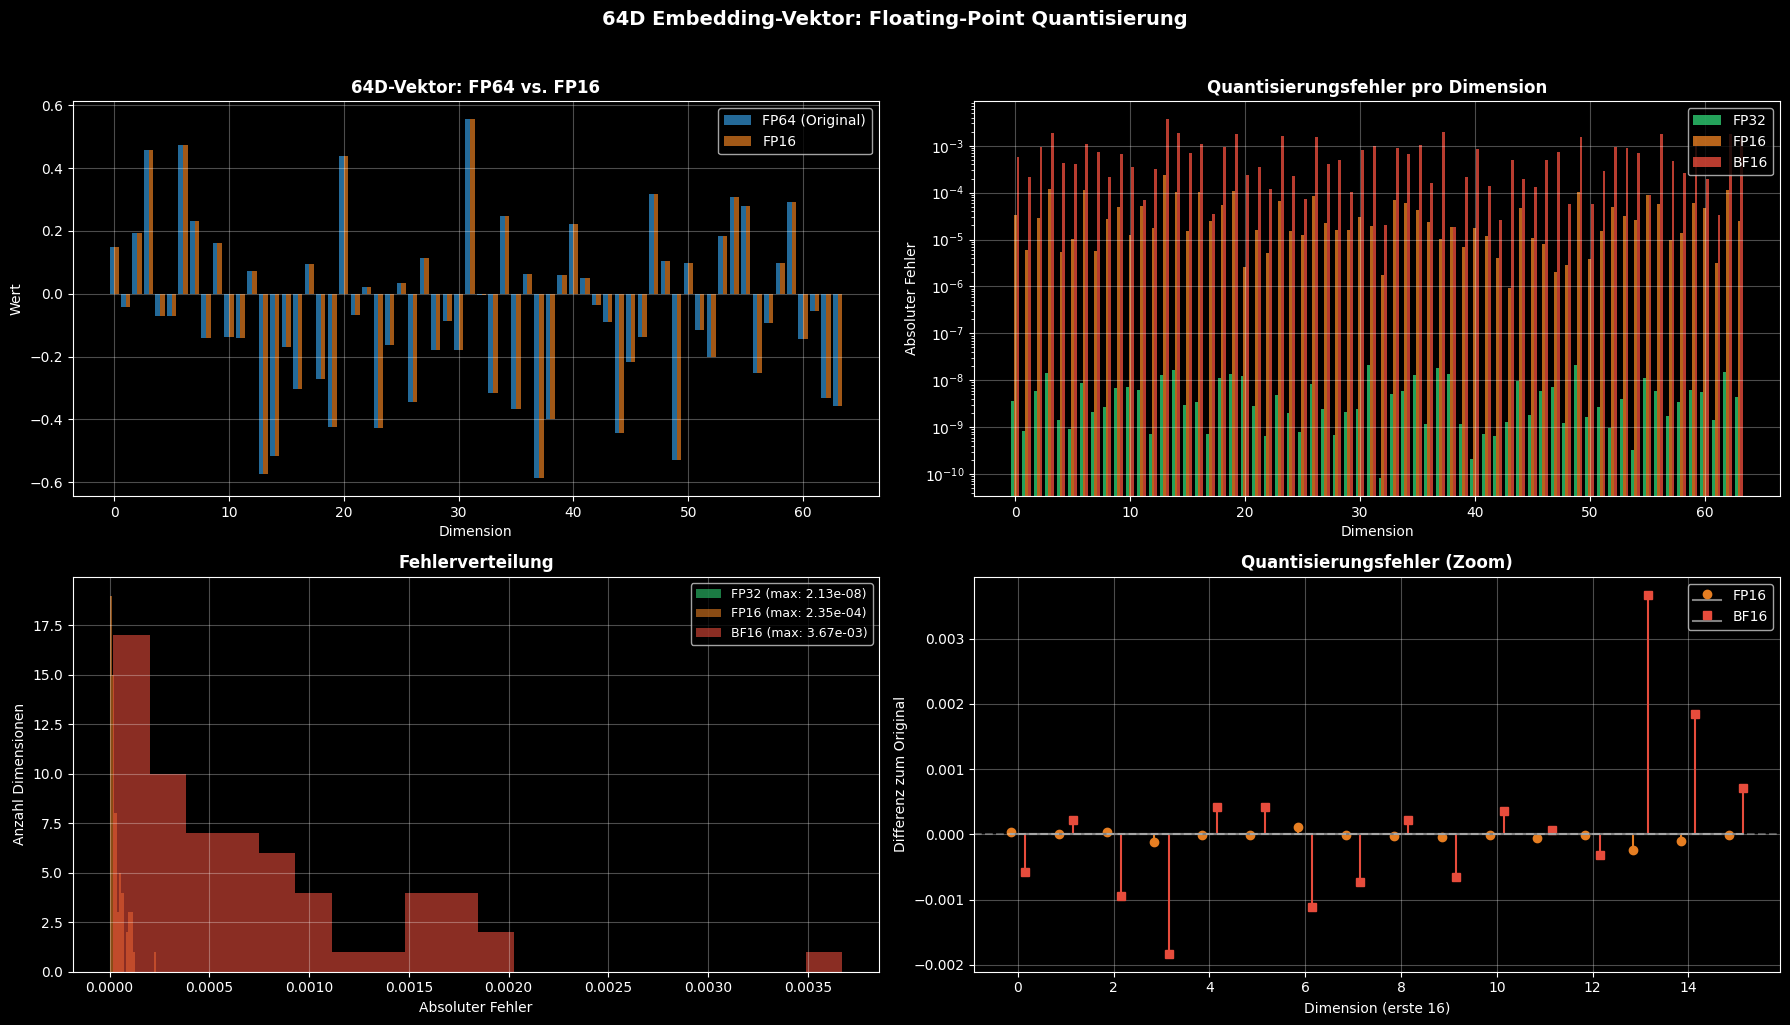

In [134]:
# ============================================================
# Visualisierung: Vektor in verschiedenen Formaten
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# --- 1. Originalvektor vs. quantisierte Versionen ---
ax1 = axes[0, 0]
x = np.arange(64)
ax1.bar(x - 0.2, vector_fp64, width=0.4, alpha=0.7, color='#3498db', label='FP64 (Original)')
ax1.bar(x + 0.2, vector_fp16.astype(float), width=0.4, alpha=0.7, color='#e67e22', label='FP16')
ax1.set_xlabel('Dimension')
ax1.set_ylabel('Wert')
ax1.set_title('64D-Vektor: FP64 vs. FP16', fontweight='bold')
ax1.legend()

# --- 2. Absoluter Fehler pro Dimension ---
ax2 = axes[0, 1]
err_fp32 = np.abs(vector_fp64 - vector_fp32.astype(np.float64))
err_fp16 = np.abs(vector_fp64 - vector_fp16.astype(np.float64))
err_bf16 = np.abs(vector_fp64 - vector_bf16.astype(np.float64))

ax2.bar(x - 0.25, err_fp32, width=0.25, alpha=0.8, color='#2ecc71', label='FP32')
ax2.bar(x, err_fp16, width=0.25, alpha=0.8, color='#e67e22', label='FP16')
ax2.bar(x + 0.25, err_bf16, width=0.25, alpha=0.8, color='#e74c3c', label='BF16')
ax2.set_xlabel('Dimension')
ax2.set_ylabel('Absoluter Fehler')
ax2.set_title('Quantisierungsfehler pro Dimension', fontweight='bold')
ax2.legend()
ax2.set_yscale('log')

# --- 3. Fehlerverteilung als Histogramm ---
ax3 = axes[1, 0]
ax3.hist(err_fp32, bins=20, alpha=0.6, color='#2ecc71', label=f'FP32 (max: {err_fp32.max():.2e})')
ax3.hist(err_fp16, bins=20, alpha=0.6, color='#e67e22', label=f'FP16 (max: {err_fp16.max():.2e})')
ax3.hist(err_bf16, bins=20, alpha=0.6, color='#e74c3c', label=f'BF16 (max: {err_bf16.max():.2e})')
ax3.set_xlabel('Absoluter Fehler')
ax3.set_ylabel('Anzahl Dimensionen')
ax3.set_title('Fehlerverteilung', fontweight='bold')
ax3.legend(fontsize=9)

# --- 4. Differenz zum Original (Zoom auf erste 16 Dimensionen) ---
ax4 = axes[1, 1]
dims = np.arange(16)
diff_fp16 = (vector_fp16.astype(np.float64) - vector_fp64)[:16]
diff_bf16 = (vector_bf16.astype(np.float64) - vector_fp64)[:16]

ax4.stem(dims - 0.15, diff_fp16, linefmt='#e67e22', markerfmt='o', basefmt='gray', label='FP16')
ax4.stem(dims + 0.15, diff_bf16, linefmt='#e74c3c', markerfmt='s', basefmt='gray', label='BF16')
ax4.axhline(y=0, color='white', linestyle='--', alpha=0.3)
ax4.set_xlabel('Dimension (erste 16)')
ax4.set_ylabel('Differenz zum Original')
ax4.set_title('Quantisierungsfehler (Zoom)', fontweight='bold')
ax4.legend()

plt.suptitle('64D Embedding-Vektor: Floating-Point Quantisierung',
             fontsize=14, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

**Oben links:** FP64 und FP16 sind visuell kaum unterscheidbar — die Balken überlagern sich fast perfekt. **Oben rechts:** Die logarithmische Skala zeigt, dass FP32-Fehler um Größenordnungen kleiner sind als FP16/BF16. **Unten links:** BF16-Fehler sind breiter gestreut als FP16-Fehler. **Unten rechts:** Im Zoom sieht man, dass die Fehler bei beiden Formaten symmetrisch um Null streuen — es gibt keinen systematischen Bias.

<a id="sec-integer-quant"></a>

## 5. Integer-Quantisierung (INT8, INT4 und die Grenzen)

Bisher haben wir nur Float-Formate betrachtet (FP32, FP16, BF16) — was passiert, wenn wir Gewichte stattdessen als **Ganzzahlen** speichern?

Integer-Quantisierung bildet Floating-Point-Werte auf ganzzahlige Werte ab.
Dafür braucht man einen **Scale Factor** und optional einen **Zero Point**:

### Symmetrische Quantisierung
$$x_q = \text{round}\left(\frac{x}{s}\right) \quad \text{mit} \quad s = \frac{\max(|x|)}{2^{b-1} - 1}$$

Dabei teilt der Scale Factor $s$ den Wertebereich so auf, dass der größte Absolutwert genau auf den maximalen Integer-Wert abgebildet wird. `round()` rundet auf die nächste Ganzzahl.

### Asymmetrische Quantisierung
$$x_q = \text{round}\left(\frac{x}{s}\right) + z$$

Hier verschiebt ein zusätzlicher **Zero Point** $z$ das Intervall, sodass auch asymmetrische Werteverteilungen (z.B. nur positive Werte nach ReLU) optimal abgedeckt werden.

### Dequantisierung (Rückrechnung)
$$\hat{x} = (x_q - z) \cdot s$$

| Format | Wertebereich | Stufen | Typischer Einsatz |
|--------|-------------|--------|-------------------|
| INT8   | -128 bis 127 | 256    | Cosine Similarity > 0.999 bei 75% Speichereinsparung |
| INT4   | -8 bis 7     | 16     | Cosine Similarity > 0.99 bei 87.5% Speichereinsparung |
| INT2   | -2 bis 1     | 4      | Nur 4 mögliche Werte — zeigt die Grenzen der Quantisierung |

Im Folgenden verwenden wir die symmetrische Variante, um die Effekte direkt zu sehen.

In [135]:
def quantize_symmetric(values, bits):
    """Symmetrische Quantisierung auf n Bits."""
    qmax = 2 ** (bits - 1) - 1
    qmin = -(2 ** (bits - 1))
    scale = np.max(np.abs(values)) / qmax
    quantized = np.clip(np.round(values / scale), qmin, qmax).astype(np.int32)
    dequantized = quantized * scale
    return quantized, scale, dequantized


# Demonstration: Block von 8 Werten
demo_values = np.array([3.14159, -2.50000, 0.12345, 1.73205, -0.50000, 2.71828, -1.41421, 0.69315])
labels = ['π', '-2.5', '0.123', '√3', '-0.5', 'e', '-√2', 'ln2']

for bits in [8, 4, 2]:
    qmax = 2 ** (bits - 1) - 1
    q_int, scale, deq = quantize_symmetric(demo_values, bits)
    errs = np.abs(demo_values - deq)

    df_demo = pd.DataFrame({
        'Original':      [f'{v:+.5f}' for v in demo_values],
        '÷ Scale':       [f'{v/scale:+.4f}' for v in demo_values],
        'Gerundet (int)': [f'{q:+d}' for q in q_int],
        '× Scale (deq)': [f'{d:+.5f}' for d in deq],
        'Fehler':        [f'{e:.6f}' for e in errs],
    }, index=labels)

    print(f'\nINT{bits}  |  {2**bits} Stufen ({-2**(bits-1)}..{qmax})  |  '
          f'Scale = {scale:.8f}  |  Ø Fehler = {errs.mean():.6f}')
    display(df_demo)


INT8  |  256 Stufen (-128..127)  |  Scale = 0.02473693  |  Ø Fehler = 0.001879


,Original,÷ Scale,Gerundet (int),× Scale (deq),Fehler
π,+3.14159,+127.0000,+127,+3.14159,0.000000
-2.5,-2.50000,-101.0635,-101,-2.49843,0.001570
0.123,+0.12345,+4.9905,+5,+0.12368,0.000235
√3,+1.73205,+70.0188,+70,+1.73159,0.000465
-0.5,-0.50000,-20.2127,-20,-0.49474,0.005261
e,+2.71828,+109.8875,+110,+2.72106,0.002782
-√2,-1.41421,-57.1700,-57,-1.41000,0.004205
ln2,+0.69315,+28.0209,+28,+0.69263,0.000516



INT4  |  16 Stufen (-8..7)  |  Scale = 0.44879857  |  Ø Fehler = 0.091042


,Original,÷ Scale,Gerundet (int),× Scale (deq),Fehler
π,+3.14159,+7.0000,+7,+3.14159,0.000000
-2.5,-2.50000,-5.5704,-6,-2.69279,0.192791
0.123,+0.12345,+0.2751,+0,+0.00000,0.123450
√3,+1.73205,+3.8593,+4,+1.79519,0.063144
-0.5,-0.50000,-1.1141,-1,-0.44880,0.051201
e,+2.71828,+6.0568,+6,+2.69279,0.025489
-√2,-1.41421,-3.1511,-3,-1.34640,0.067814
ln2,+0.69315,+1.5445,+2,+0.89760,0.204447



INT2  |  4 Stufen (-2..1)  |  Scale = 3.14159000  |  Ø Fehler = 0.650656


,Original,÷ Scale,Gerundet (int),× Scale (deq),Fehler
π,+3.14159,+1.0000,+1,+3.14159,0.000000
-2.5,-2.50000,-0.7958,-1,-3.14159,0.641590
0.123,+0.12345,+0.0393,+0,+0.00000,0.123450
√3,+1.73205,+0.5513,+1,+3.14159,1.409540
-0.5,-0.50000,-0.1592,+0,+0.00000,0.500000
e,+2.71828,+0.8653,+1,+3.14159,0.423310
-√2,-1.41421,-0.4502,+0,+0.00000,1.414210
ln2,+0.69315,+0.2206,+0,+0.00000,0.693150


Die Tabellen zeigen den vollständigen Quantisierungsprozess: Original → durch Scale teilen → auf Ganzzahl runden → mit Scale zurückmultiplizieren. Bei INT8 (256 Stufen) ist der Fehler minimal. Bei INT4 (16 Stufen) werden kleine Werte wie `0.123` bereits merklich verzerrt. Bei INT2 (nur 4 mögliche Werte: -2, -1, 0, 1) geht so viel Information verloren, dass die Rückrechnung kaum noch dem Original entspricht.

In [136]:
q_int8, scale_8, deq_int8 = quantize_symmetric(vector_fp64, 8)
q_int4, scale_4, deq_int4 = quantize_symmetric(vector_fp64, 4)
q_int2, scale_2, deq_int2 = quantize_symmetric(vector_fp64, 2)

# Fehlermetriken
int_errors = [
    compute_errors(vector_fp64, deq_int8, 'INT8'),
    compute_errors(vector_fp64, deq_int4, 'INT4'),
    compute_errors(vector_fp64, deq_int2, 'INT2'),
]

df_metrics = pd.DataFrame({
    'Scale Factor':      [f'{s:.8f}' for s in [scale_8, scale_4, scale_2]],
    'MSE':               [f'{e["mse"]:.2e}' for e in int_errors],
    'Max. Fehler':       [f'{e["max_error"]:.2e}' for e in int_errors],
    'Cosine Similarity': [f'{e["cos_sim"]:.10f}' for e in int_errors],
}, index=['INT8 (256 Stufen)', 'INT4 (16 Stufen)', 'INT2 (4 Stufen)'])

display(df_metrics)

# Werte-Vergleich
n_show = 10
df_int = pd.DataFrame({
    'Original (FP64)': [f'{v:+.8f}' for v in vector_fp64[:n_show]],
    'INT8 q':          [f'{q:+4d}' for q in q_int8[:n_show]],
    'INT8 deq':        [f'{d:+.8f}' for d in deq_int8[:n_show]],
    'INT4 q':          [f'{q:+2d}' for q in q_int4[:n_show]],
    'INT4 deq':        [f'{d:+.8f}' for d in deq_int4[:n_show]],
    '|Δ INT8|':        [f'{abs(vector_fp64[i] - deq_int8[i]):.2e}' for i in range(n_show)],
    '|Δ INT4|':        [f'{abs(vector_fp64[i] - deq_int4[i]):.2e}' for i in range(n_show)],
}, index=[f'Dim [{i}]' for i in range(n_show)])

display(df_int)

,Scale Factor,MSE,Max. Fehler,Cosine Similarity
INT8 (256 Stufen),0.00462914,1.68e-06,2.29e-03,0.9999889247
INT4 (16 Stufen),0.08398586,5.17e-04,4.15e-02,0.9965409380
INT2 (4 Stufen),0.58790104,2.69e-02,2.93e-01,0.8674980044


,Original (FP64),INT8 q,INT8 deq,INT4 q,INT4 deq,|Δ INT8|,|Δ INT4|
Dim [0],+0.14901425,+32,+0.14813254,+2,+0.16797172,8.82e-04,1.90e-02
Dim [1],-0.04147929,-9,-0.04166228,+0,+0.00000000,1.83e-04,4.15e-02
Dim [2],+0.19430656,+42,+0.19442397,+2,+0.16797172,1.17e-04,2.63e-02
Dim [3],+0.45690896,+99,+0.45828506,+5,+0.41992931,1.38e-03,3.70e-02
Dim [4],-0.07024601,-15,-0.06943713,-1,-0.08398586,8.09e-04,1.37e-02
Dim [5],-0.07024109,-15,-0.06943713,-1,-0.08398586,8.04e-04,1.37e-02
Dim [6],+0.47376384,+102,+0.47217249,+6,+0.50391517,1.59e-03,3.02e-02
Dim [7],+0.23023042,+50,+0.23145710,+3,+0.25195759,1.23e-03,2.17e-02
Dim [8],-0.14084232,-30,-0.13887426,-2,-0.16797172,1.97e-03,2.71e-02
Dim [9],+0.16276801,+35,+0.16201997,+2,+0.16797172,7.48e-04,5.20e-03


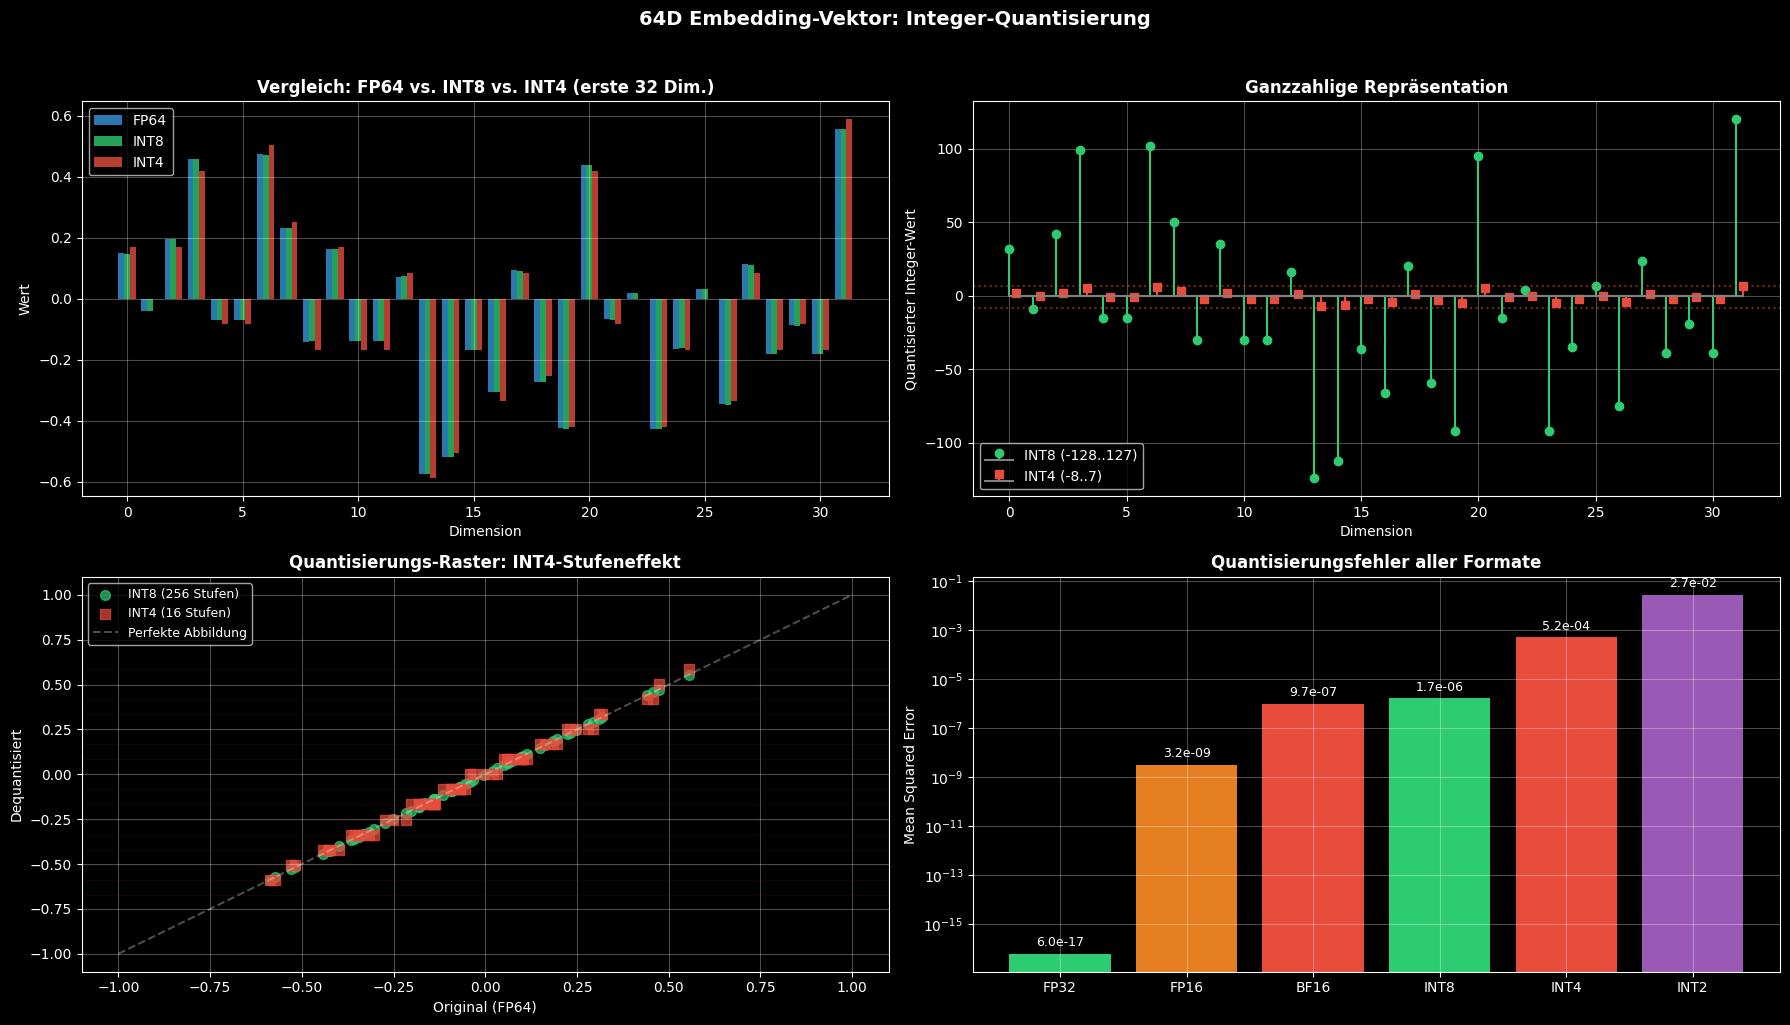

In [137]:
# ============================================================
# Visualisierung: INT8 vs. INT4 Quantisierung
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# --- 1. Original vs. INT8 vs. INT4 (erste 32 Dimensionen) ---
ax1 = axes[0, 0]
dims32 = np.arange(32)
width = 0.25
ax1.bar(dims32 - width, vector_fp64[:32], width=width, alpha=0.8, color='#3498db', label='FP64')
ax1.bar(dims32, deq_int8[:32], width=width, alpha=0.8, color='#2ecc71', label='INT8')
ax1.bar(dims32 + width, deq_int4[:32], width=width, alpha=0.8, color='#e74c3c', label='INT4')
ax1.set_xlabel('Dimension')
ax1.set_ylabel('Wert')
ax1.set_title('Vergleich: FP64 vs. INT8 vs. INT4 (erste 32 Dim.)', fontweight='bold')
ax1.legend()

# --- 2. Quantisierte Integer-Werte ---
ax2 = axes[0, 1]
ax2.stem(dims32, q_int8[:32], linefmt='#2ecc71', markerfmt='o', basefmt='gray', label='INT8 (-128..127)')
ax2.stem(dims32 + 0.3, q_int4[:32], linefmt='#e74c3c', markerfmt='s', basefmt='gray', label='INT4 (-8..7)')
ax2.set_xlabel('Dimension')
ax2.set_ylabel('Quantisierter Integer-Wert')
ax2.set_title('Ganzzahlige Repr\u00e4sentation', fontweight='bold')
ax2.legend()
ax2.axhline(y=7, color='#e74c3c', linestyle=':', alpha=0.5)
ax2.axhline(y=-8, color='#e74c3c', linestyle=':', alpha=0.5)

# --- 3. Quantisierungs-Raster: INT4 hat nur 16 mögliche Werte ---
ax3 = axes[1, 0]
# Zeige die möglichen dequantisierten Werte
possible_int4 = np.arange(-8, 8) * scale_4
possible_int8 = np.arange(-128, 128) * scale_8

ax3.scatter(vector_fp64, deq_int8, alpha=0.7, color='#2ecc71', s=50, label='INT8 (256 Stufen)')
ax3.scatter(vector_fp64, deq_int4, alpha=0.7, color='#e74c3c', s=50, label='INT4 (16 Stufen)', marker='s')
ax3.plot([-1, 1], [-1, 1], 'w--', alpha=0.3, label='Perfekte Abbildung')

# Horizontale Linien für INT4-Stufen
for v in possible_int4:
    ax3.axhline(y=v, color='#e74c3c', alpha=0.1, linewidth=0.5)

ax3.set_xlabel('Original (FP64)')
ax3.set_ylabel('Dequantisiert')
ax3.set_title('Quantisierungs-Raster: INT4-Stufeneffekt', fontweight='bold')
ax3.legend(fontsize=9)

# --- 4. Gesamtvergleich aller Formate ---
ax4 = axes[1, 1]
all_errors = errors + int_errors  # FP32, FP16, BF16, INT8, INT4, INT2
names = [e['name'] for e in all_errors]
mse_vals = [e['mse'] for e in all_errors]
cos_vals = [1 - e['cos_sim'] for e in all_errors]  # 1 - cos für bessere Sichtbarkeit

x_pos = np.arange(len(names))
bars = ax4.bar(x_pos, mse_vals, color=['#2ecc71', '#e67e22', '#e74c3c', '#2ecc71', '#e74c3c', '#9b59b6'])
ax4.set_xticks(x_pos)
ax4.set_xticklabels(names)
ax4.set_ylabel('Mean Squared Error')
ax4.set_title('Quantisierungsfehler aller Formate', fontweight='bold')
ax4.set_yscale('log')

for bar, mse in zip(bars, mse_vals):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 1.5,
             f'{mse:.1e}', ha='center', va='bottom', fontsize=9)

plt.suptitle('64D Embedding-Vektor: Integer-Quantisierung',
             fontsize=14, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

**Oben links:** INT8 folgt dem Original fast perfekt, INT4 zeigt sichtbare Abweichungen. **Oben rechts:** Die ganzzahlige Repräsentation — INT4 nutzt nur den Bereich -8 bis 7 (gestrichelte Linien). **Unten links:** Das Quantisierungs-Raster zeigt den Stufeneffekt: INT4 kann Werte nur auf 16 feste Positionen abbilden (rote horizontale Linien). Werte zwischen zwei Stufen werden auf die nächstliegende gerundet. **Unten rechts:** Der MSE-Vergleich aller Formate auf logarithmischer Skala — INT4 liegt zwischen FP16 und BF16.

<a id="sec-block-quant"></a>

## 6. Block-Quantisierung (GGUF-Stil)

Ein einzelner globaler Scale Factor für den gesamten Tensor verschwendet Auflösung: Wenn ein einzelner Ausreißer den Scale Factor dominiert, stehen für die übrigen (kleineren) Werte nur wenige der verfügbaren Integer-Stufen zur Verfügung.

Die Lösung: den Tensor in **Blöcke** (typisch: 32 Werte) aufteilen. Jeder Block bekommt seinen eigenen Scale Factor und nutzt damit seinen lokalen Wertebereich optimal aus.

Das ist der Ansatz von **GGUF** (llama.cpp, LM Studio, Ollama):

| GGUF-Typ | Bits/Gewicht | Block-Größe | Overhead (Scale) | Effektive Bits |
|----------|-------------|------------|-------------------|----------------|
| Q8_0     | 8           | 32         | 16 Bit (FP16)     | ~8.5           |
| Q4_0     | 4           | 32         | 16 Bit (FP16)     | ~4.5           |

In [138]:
def block_quantize(values, bits, block_size=32):
    """Block-Quantisierung im GGUF-Stil.
    Jeder Block von `block_size` Werten bekommt seinen eigenen Scale Factor."""
    n = len(values)
    padded = np.zeros(((n + block_size - 1) // block_size) * block_size)
    padded[:n] = values

    qmax = 2 ** (bits - 1) - 1
    qmin = -(2 ** (bits - 1))

    quantized = np.zeros_like(padded, dtype=np.int32)
    scales = []

    for i in range(0, len(padded), block_size):
        block = padded[i:i+block_size]
        block_max = np.max(np.abs(block))
        scale = block_max / qmax if block_max > 0 else 1.0
        scales.append(scale)
        quantized[i:i+block_size] = np.clip(np.round(block / scale), qmin, qmax)

    dequantized = np.zeros_like(padded)
    for i, (start, scale) in enumerate(zip(range(0, len(padded), block_size), scales)):
        dequantized[start:start+block_size] = quantized[start:start+block_size] * scale

    return quantized[:n], scales, dequantized[:n]


# Größerer Vektor für Block-Quantisierung (256 Werte = 8 Blöcke)
np.random.seed(42)
large_vector = np.random.randn(256).astype(np.float64) * 0.3

bq_int8, scales_8, bdeq_int8 = block_quantize(large_vector, 8, block_size=32)
bq_int4, scales_4_block, bdeq_int4 = block_quantize(large_vector, 4, block_size=32)

# Global vs. Block Quantisierung vergleichen
_, _, global_deq_int4 = quantize_symmetric(large_vector, 4)

err_global = compute_errors(large_vector, global_deq_int4, 'INT4 Global')
err_block = compute_errors(large_vector, bdeq_int4, 'INT4 Block (Q4_0)')
err_block8 = compute_errors(large_vector, bdeq_int8, 'INT8 Block (Q8_0)')

df_block = pd.DataFrame({
    'MSE':             [f'{e["mse"]:.2e}' for e in [err_block8, err_block, err_global]],
    'Max. Fehler':     [f'{e["max_error"]:.2e}' for e in [err_block8, err_block, err_global]],
    'Cosine Similarity': [f'{e["cos_sim"]:.10f}' for e in [err_block8, err_block, err_global]],
}, index=[err_block8['name'], err_block['name'], err_global['name']])

display(df_block)

# Scale-Tabelle pro Block
df_scales = pd.DataFrame({
    'Index-Bereich':  [f'{i*32}–{i*32+31}' for i in range(len(scales_4_block))],
    'Scale (Q4_0)':   [f'{s:.6f}' for s in scales_4_block],
    'Scale (Q8_0)':   [f'{s:.6f}' for s in scales_8],
    'Block max(|x|)': [f'{np.max(np.abs(large_vector[i*32:(i+1)*32])):.6f}' for i in range(len(scales_4_block))],
}, index=[f'Block {i}' for i in range(len(scales_4_block))])

display(df_scales)

,MSE,Max. Fehler,Cosine Similarity
INT8 Block (Q8_0),2.84e-06,4.42e-03,0.9999834135
INT4 Block (Q4_0),7.92e-04,8.21e-02,0.9953781308
INT4 Global,2.52e-03,8.21e-02,0.9855285709


,Index-Bereich,Scale (Q4_0),Scale (Q8_0),Block max(|x|)
Block 0,0–31,0.081998,0.004520,0.573984
Block 1,32–63,0.083986,0.004629,0.587901
Block 2,64–95,0.112275,0.006188,0.785924
Block 3,96–127,0.105568,0.005819,0.738973
Block 4,128–159,0.079962,0.004407,0.559732
Block 5,160–191,0.116579,0.006426,0.816051
Block 6,192–223,0.165117,0.009101,1.155819
Block 7,224–255,0.091883,0.005064,0.643183


Block-Quantisierung erzielt geringere Fehler, weil jeder Block seinen eigenen Scale Factor erhält und damit den lokalen Wertebereich optimal abdeckt. Die Scale-Tabelle zeigt: Blöcke mit kleinen Werten bekommen einen kleinen Scale Factor und nutzen dadurch die verfügbaren Integer-Stufen besser aus als bei einem einzigen globalen Scale Factor.

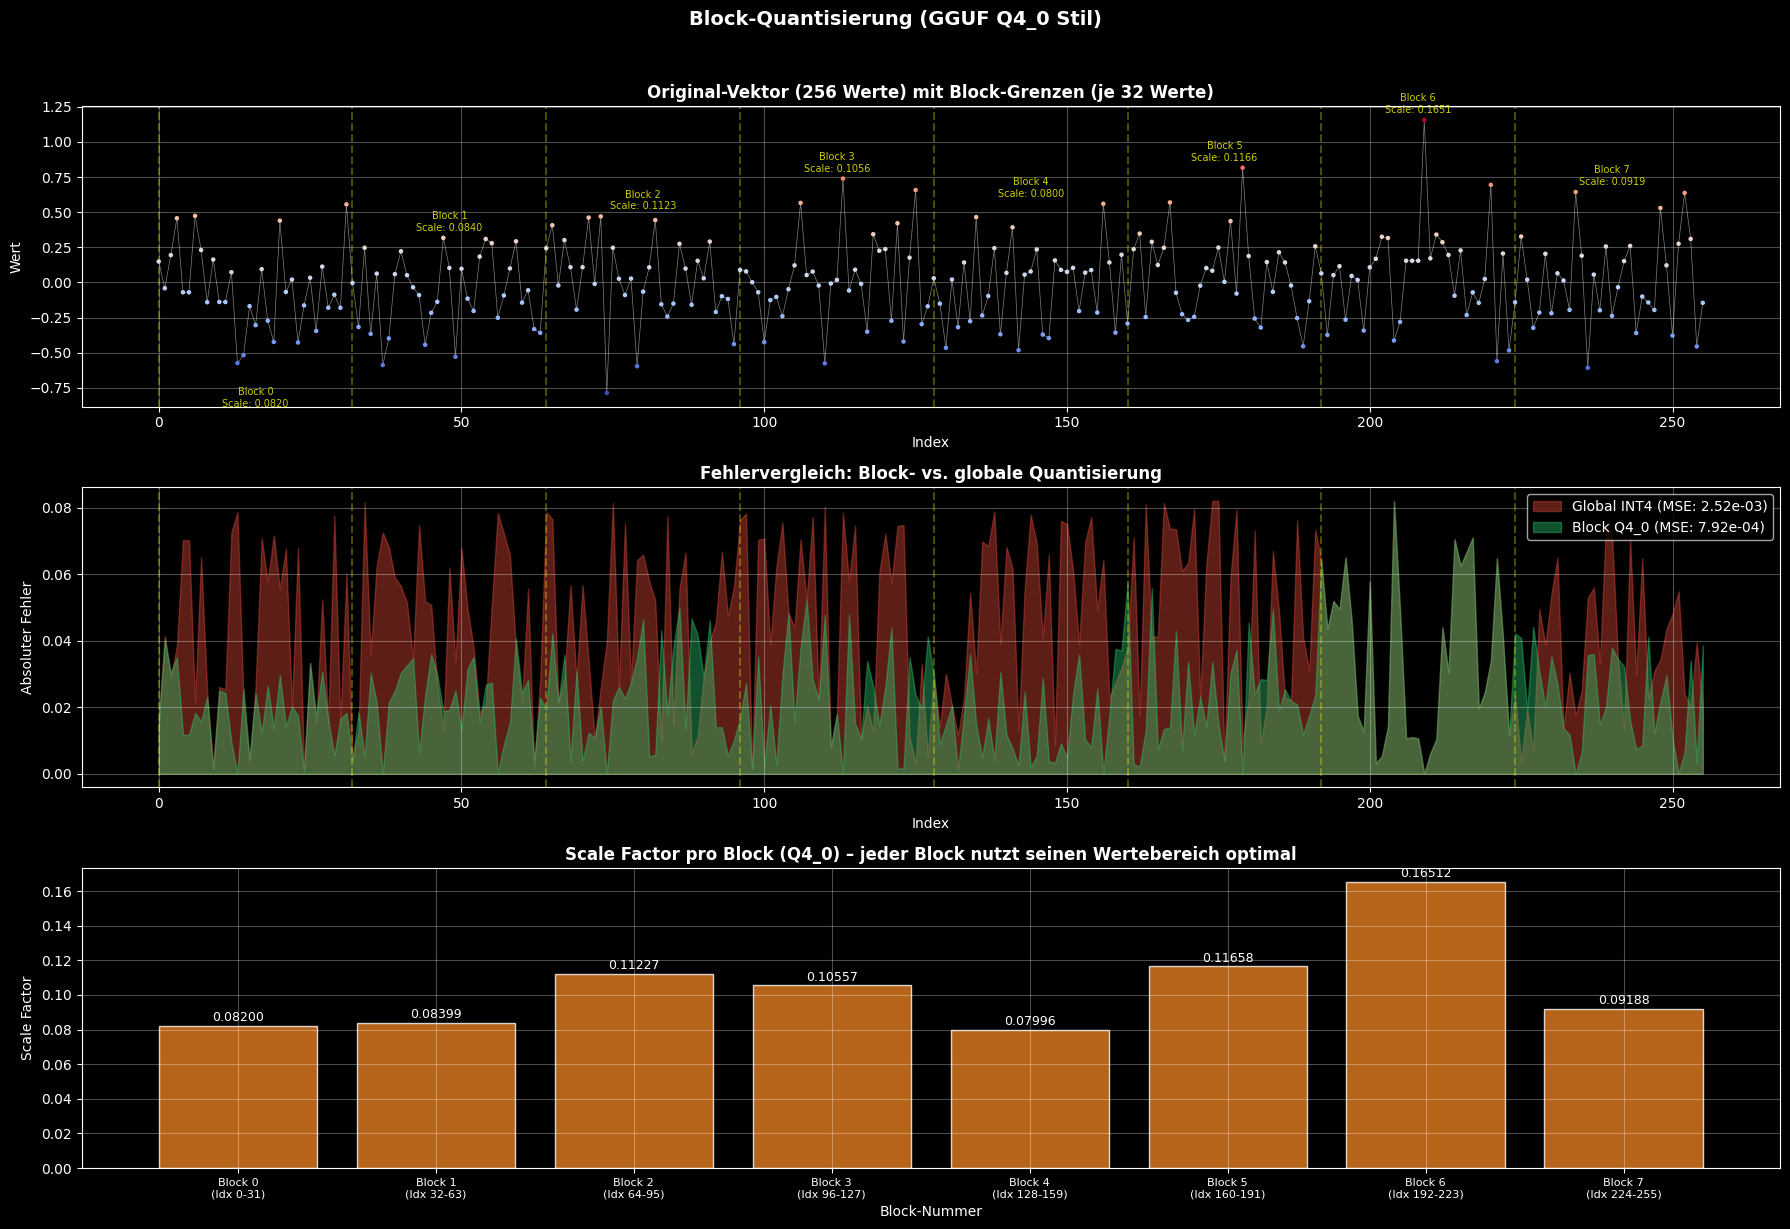

In [139]:
# ============================================================
# Visualisierung: Block-Quantisierung
# ============================================================

fig, axes = plt.subplots(3, 1, figsize=(18, 12))

# --- 1. Originalvektor mit Block-Grenzen ---
ax1 = axes[0]
x_large = np.arange(256)
ax1.plot(x_large, large_vector, 'w-', alpha=0.5, linewidth=0.5)
ax1.scatter(x_large, large_vector, c=large_vector, cmap='coolwarm', s=5, zorder=3)

# Block-Grenzen
for i in range(0, 256, 32):
    ax1.axvline(x=i, color='yellow', alpha=0.3, linestyle='--')
    ax1.text(i + 16, ax1.get_ylim()[0] if i == 0 else large_vector[i:i+32].max() + 0.05,
             f'Block {i//32}\nScale: {scales_4_block[i//32]:.4f}',
             ha='center', fontsize=7, color='yellow', alpha=0.8)

ax1.set_title('Original-Vektor (256 Werte) mit Block-Grenzen (je 32 Werte)', fontweight='bold')
ax1.set_xlabel('Index')
ax1.set_ylabel('Wert')

# --- 2. Block Q4_0 vs. Global INT4 ---
ax2 = axes[1]
err_block_vals = np.abs(large_vector - bdeq_int4)
err_global_vals = np.abs(large_vector - global_deq_int4)

ax2.fill_between(x_large, err_global_vals, alpha=0.4, color='#e74c3c', label=f'Global INT4 (MSE: {err_global["mse"]:.2e})')
ax2.fill_between(x_large, err_block_vals, alpha=0.4, color='#2ecc71', label=f'Block Q4_0 (MSE: {err_block["mse"]:.2e})')

for i in range(0, 256, 32):
    ax2.axvline(x=i, color='yellow', alpha=0.3, linestyle='--')

ax2.set_title('Fehlervergleich: Block- vs. globale Quantisierung', fontweight='bold')
ax2.set_xlabel('Index')
ax2.set_ylabel('Absoluter Fehler')
ax2.legend()

# --- 3. Scale Factors pro Block ---
ax3 = axes[2]
block_ids = np.arange(len(scales_4_block))
bars = ax3.bar(block_ids, scales_4_block, color='#e67e22', alpha=0.8, edgecolor='white')
ax3.set_xlabel('Block-Nummer')
ax3.set_ylabel('Scale Factor')
ax3.set_title('Scale Factor pro Block (Q4_0) \u2013 jeder Block nutzt seinen Wertebereich optimal', fontweight='bold')
ax3.set_xticks(block_ids)
ax3.set_xticklabels([f'Block {i}\n(Idx {i*32}-{i*32+31})' for i in block_ids], fontsize=8)

for bar, s in zip(bars, scales_4_block):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{s:.5f}', ha='center', va='bottom', fontsize=9)

plt.suptitle('Block-Quantisierung (GGUF Q4_0 Stil)',
             fontsize=14, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

**Oben:** Der Originalvektor mit den 8 Block-Grenzen (gelbe Linien). Jeder Block hat einen eigenen Scale Factor. **Mitte:** Der Block-Q4_0-Fehler (grün) liegt fast überall unter dem globalen INT4-Fehler (rot) — besonders in Bereichen mit kleinen Werten ist der Unterschied deutlich. **Unten:** Die Scale Factors variieren von Block zu Block, je nach dem maximalen Absolutwert im jeweiligen Block.

### GGUF-Namenskonvention: Was bedeutet Q5_K_M?

Wenn man quantisierte Modelle herunterlädt (z.B. von Hugging Face), sieht man Dateinamen wie:

```
qwen3-8b-Q4_K_M.gguf
qwen3-8b-Q5_K_S.gguf
qwen3-8b-Q8_0.gguf
```

Der Name folgt einem festen Schema:

$$\underbrace{\texttt{Q5}}_{\text{Bits}} \underbrace{\texttt{\_K}}_{\text{Methode}} \underbrace{\texttt{\_M}}_{\text{Größe}}$$

**Teil 1 – Bits (Q2, Q3, Q4, Q5, Q6, Q8):**
Die Anzahl der Bits pro Gewicht. Q4 = 4 Bit, Q8 = 8 Bit usw.

**Teil 2 – Methode:**
- **`_0` / `_1`** = Legacy-Methode: ein einziger Scale Factor pro Block (wie in Kapitel 6 gezeigt). `_1` speichert zusätzlich einen **Minimum-Wert** pro Block, um den Wertebereich asymmetrisch zu nutzen (vgl. die asymmetrische Formel aus Kapitel 5).
- **`_K`** = **K-Quant** (neuere Methode): verwendet **Mixed Precision** — verschiedene Layer des Modells werden mit unterschiedlich vielen Bits quantisiert. Attention-Layer bestimmen, welche Informationen weitergegeben werden, und sind empfindlicher gegenüber Quantisierungsfehlern. Feed-Forward-Layer sind robuster, weil sie hauptsächlich elementweise Transformationen durchführen. K-Quant gibt daher Attention-Layern mehr Bits und spart bei FFN-Layern.
- **`IQ`** = **Importance Quantization**: Statt gleichmäßig verteilter Quantisierungsstufen (wie bei Q4_0) werden die Stufen dort platziert, wo die häufigsten Gewichtswerte liegen — ähnlich wie bei der Huffman-Codierung. Aktuell die beste Qualität bei extrem niedrigen Bitrates (2–4 Bit).

**Teil 3 – Größen-Suffix (nur bei K-Quants):**
- **`_S`** (Small) = aggressiver quantisiert → kleinere Datei, etwas mehr Qualitätsverlust
- **`_M`** (Medium) = ausgewogener Kompromiss → **empfohlen für die meisten Anwendungsfälle**
- **`_L`** (Large) = weniger aggressiv → größere Datei, bessere Qualität

In [140]:
# Effektive Bits pro Gewicht (Werte basierend auf llama.cpp-Dokumentation)
gguf_types = [
    ('Q8_0',    8.50,  'Legacy',     '–',   'Quasi verlustfrei, nur für Tests'),
    ('Q6_K',    6.57,  'K-Quant',    '–',   'Sehr gute Qualität'),
    ('Q5_K_L',  5.75,  'K-Quant',    'L',   'Gute Qualität, große Variante'),
    ('Q5_K_M',  5.69,  'K-Quant',    'M',   'Gute Qualität, empfohlen'),
    ('Q5_K_S',  5.54,  'K-Quant',    'S',   'Gute Qualität, kompakter'),
    ('Q5_0',    5.50,  'Legacy',     '–',   'Legacy, besser Q5_K_M nehmen'),
    ('Q4_K_M',  4.85,  'K-Quant',    'M',   'Bester Kompromiss, sehr beliebt'),
    ('Q4_K_S',  4.58,  'K-Quant',    'S',   'Kompakter, minimal schlechter'),
    ('Q4_0',    4.50,  'Legacy',     '–',   'Legacy, besser Q4_K_M nehmen'),
    ('Q3_K_M',  3.91,  'K-Quant',    'M',   'Akzeptabel, merkbarer Verlust'),
    ('Q3_K_S',  3.50,  'K-Quant',    'S',   'Spürbar schlechter'),
    ('Q2_K',    3.35,  'K-Quant',    '–',   'Nur Notfall – starker Verlust'),
    ('IQ4_XS',  4.25,  'IQ',         'XS',  'Beste Qualität bei ~4 Bit'),
    ('IQ3_XXS', 3.06,  'IQ',         'XXS', 'Erstaunlich gut für 3 Bit'),
    ('IQ2_XXS', 2.06,  'IQ',         'XXS', 'Experimentell, extremer Verlust'),
]

params_8b = 8_000_000_000

rows = []
for name, eff_bpw, method, size_tier, note in gguf_types:
    file_gb = (params_8b * eff_bpw / 8) / (10 ** 9)
    rows.append({
        'Eff. Bits': f'{eff_bpw:.2f}',
        'Methode':   method,
        'Suffix':    size_tier,
        'Qwen3-8B':  f'{file_gb:.1f} GB',
        'Hinweis':   note,
    })

df_gguf = pd.DataFrame(rows, index=[t[0] for t in gguf_types])
df_gguf.index.name = 'GGUF-Typ'

display(df_gguf)

,Eff. Bits,Methode,Suffix,Qwen3-8B,Hinweis
GGUF-Typ,,,,,
Q8_0,8.50,Legacy,–,8.5 GB,"Quasi verlustfrei, nur für Tests"
Q6_K,6.57,K-Quant,–,6.6 GB,Sehr gute Qualität
Q5_K_L,5.75,K-Quant,L,5.8 GB,"Gute Qualität, große Variante"
Q5_K_M,5.69,K-Quant,M,5.7 GB,"Gute Qualität, empfohlen"
Q5_K_S,5.54,K-Quant,S,5.5 GB,"Gute Qualität, kompakter"
Q5_0,5.50,Legacy,–,5.5 GB,"Legacy, besser Q5_K_M nehmen"
Q4_K_M,4.85,K-Quant,M,4.8 GB,"Bester Kompromiss, sehr beliebt"
Q4_K_S,4.58,K-Quant,S,4.6 GB,"Kompakter, minimal schlechter"
Q4_0,4.50,Legacy,–,4.5 GB,"Legacy, besser Q4_K_M nehmen"


**Empfehlung für die meisten Anwendungsfälle:**

- **Q4_K_M:** Bester Kompromiss aus Dateigröße und Qualität — passt auf 8 GB VRAM
- **Q5_K_M:** Wenn etwas mehr RAM verfügbar ist — spürbar bessere Qualität als Q4
- **Q8_0:** Wenn Qualität wichtiger ist als Speicher — quasi verlustfrei
- **IQ4_XS:** Wenn man das Maximum bei ~4 Bit herausholen will — besser als Q4_0 bei gleicher Größe

<a id="sec-memory"></a>

## 7. Speichereinsparung

Wir kennen jetzt die verschiedenen Formate und ihre Funktionsweise — aber wie viel Speicher spart man damit konkret? Rechnen wir es für verschiedene Modellgrößen durch.

### Dateigröße ≠ VRAM-Verbrauch

Die Tabellen unten zeigen den Speicherbedarf der **Gewichte**. Das entspricht der Dateigröße auf der Festplatte. Beim Inference auf der GPU kommt aber noch dazu:

| Komponente | Beschreibung | Größenordnung |
|------------|-------------|---------------|
| **Gewichte** | Die quantisierten Modellparameter | = Dateigröße |
| **KV-Cache** | Speichert Key/Value-Paare für jedes Token im Kontext | Wächst mit Kontextlänge — bei 32k Tokens mehrere GB |
| **Aktivierungen** | Zwischenergebnisse während des Forward-Pass | Temporär, abhängig von Batch-Größe |
| **Framework-Overhead** | CUDA-Kontext, Kernel-Buffers etc. | ~200–500 MB |

**Faustregel:** $\text{VRAM} \approx \text{Modellgröße} + \text{KV-Cache} + \sim\!1\;\text{GB Overhead}$

Bei kurzen Kontexten (< 2k Tokens) dominieren die Gewichte und die Dateigröße ist eine gute Näherung. Bei langen Kontexten (32k+) kann der KV-Cache signifikant werden.

In [141]:
model_sizes = {
    'GPT-2':       124_000_000,
    'Qwen3-8B':    8_000_000_000,
    'Qwen3-30B':   30_000_000_000,
    'Qwen3-235B':  235_000_000_000,
}

format_bytes = {
    'FP32':        4.0,
    'FP16':        2.0,
    'BF16':        2.0,
    'INT8 (Q8_0)': 1.0 + 2/32,
    'INT5 (Q5_0)': 5/8 + 2/32,
    'INT4 (Q4_0)': 0.5 + 2/32,
}

# Speichertabelle
rows = {}
for model_name, params in model_sizes.items():
    row = {}
    for fmt, bpw in format_bytes.items():
        size_gb = (params * bpw) / (10 ** 9)
        row[fmt] = f'{size_gb:.1f} GB'
    rows[model_name] = row

df_memory = pd.DataFrame(rows).T
df_memory.index.name = 'Modell'
display(df_memory)

# Einsparungstabelle
savings_rows = []
for fmt, bpw in format_bytes.items():
    if fmt == 'FP32':
        continue
    saving = (1 - bpw / 4.0) * 100
    ratio = 4.0 / bpw
    savings_rows.append({
        'Bits/Gewicht':  f'{bpw * 8:.0f}',
        'Bytes/Gewicht': f'{bpw:.3f}',
        'Einsparung':    f'{saving:.1f}%',
        'Kompression':   f'{ratio:.1f}x',
    })

df_savings = pd.DataFrame(savings_rows, index=[f for f in format_bytes if f != 'FP32'])
display(df_savings)

,FP32,FP16,BF16,INT8 (Q8_0),INT5 (Q5_0),INT4 (Q4_0)
Modell,,,,,,
GPT-2,0.5 GB,0.2 GB,0.2 GB,0.1 GB,0.1 GB,0.1 GB
Qwen3-8B,32.0 GB,16.0 GB,16.0 GB,8.5 GB,5.5 GB,4.5 GB
Qwen3-30B,120.0 GB,60.0 GB,60.0 GB,31.9 GB,20.6 GB,16.9 GB
Qwen3-235B,940.0 GB,470.0 GB,470.0 GB,249.7 GB,161.6 GB,132.2 GB


,Bits/Gewicht,Bytes/Gewicht,Einsparung,Kompression
FP16,16,2.000,50.0%,2.0x
BF16,16,2.000,50.0%,2.0x
INT8 (Q8_0),8,1.062,73.4%,3.8x
INT5 (Q5_0),6,0.688,82.8%,5.8x
INT4 (Q4_0),4,0.562,85.9%,7.1x


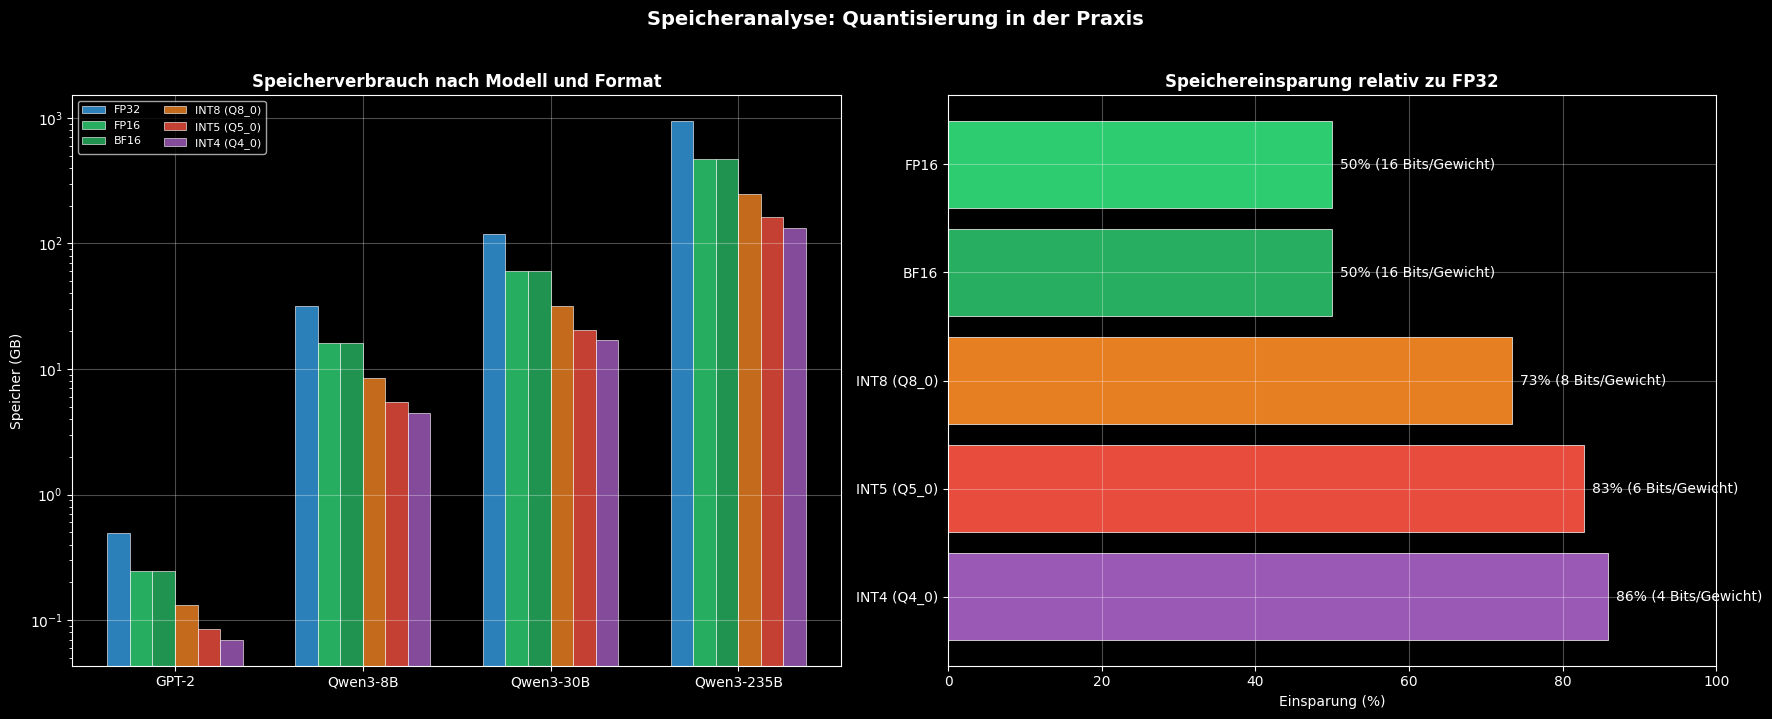

In [142]:
# ============================================================
# Visualisierung: Speichereinsparung
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# --- 1. Speicherverbrauch pro Modell ---
ax1 = axes[0]
x_models = np.arange(len(model_sizes))
width = 0.12
colors = ['#3498db', '#2ecc71', '#27ae60', '#e67e22', '#e74c3c', '#9b59b6']

for i, (fmt, bpw) in enumerate(format_bytes.items()):
    sizes_gb = [(params * bpw) / (10 ** 9) for params in model_sizes.values()]
    bars = ax1.bar(x_models + i * width, sizes_gb, width=width,
                   label=fmt, color=colors[i], alpha=0.85, edgecolor='white', linewidth=0.5)

ax1.set_xticks(x_models + width * 2.5)
ax1.set_xticklabels(model_sizes.keys(), fontsize=10)
ax1.set_ylabel('Speicher (GB)')
ax1.set_title('Speicherverbrauch nach Modell und Format', fontweight='bold')
ax1.legend(fontsize=8, ncol=2)
ax1.set_yscale('log')

# --- 2. Einsparung als Balkendiagramm ---
ax2 = axes[1]
fmt_names = [f for f in format_bytes if f != 'FP32']
savings = [(1 - format_bytes[f] / 4.0) * 100 for f in fmt_names]
bits_per_weight = [format_bytes[f] * 8 for f in fmt_names]

bars2 = ax2.barh(range(len(fmt_names)), savings,
                 color=['#2ecc71', '#27ae60', '#e67e22', '#e74c3c', '#9b59b6'],
                 edgecolor='white', linewidth=0.5)
ax2.set_yticks(range(len(fmt_names)))
ax2.set_yticklabels(fmt_names)
ax2.set_xlabel('Einsparung (%)')
ax2.set_title('Speichereinsparung relativ zu FP32', fontweight='bold')

for bar, saving, bpw in zip(bars2, savings, bits_per_weight):
    ax2.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
             f'{saving:.0f}% ({bpw:.0f} Bits/Gewicht)',
             va='center', fontsize=10)

ax2.set_xlim(0, 100)
ax2.invert_yaxis()

plt.suptitle('Speicheranalyse: Quantisierung in der Praxis',
             fontsize=14, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

<a id="sec-quality"></a>

## 8. Qualitätsvergleich: Alle Formate auf einen Blick

Entscheidend ist, ob die **Vektorrichtung** — und damit die semantische Information — trotz Quantisierung erhalten bleibt. Die **Cosine Similarity** ist die wichtigste Metrik dafür.

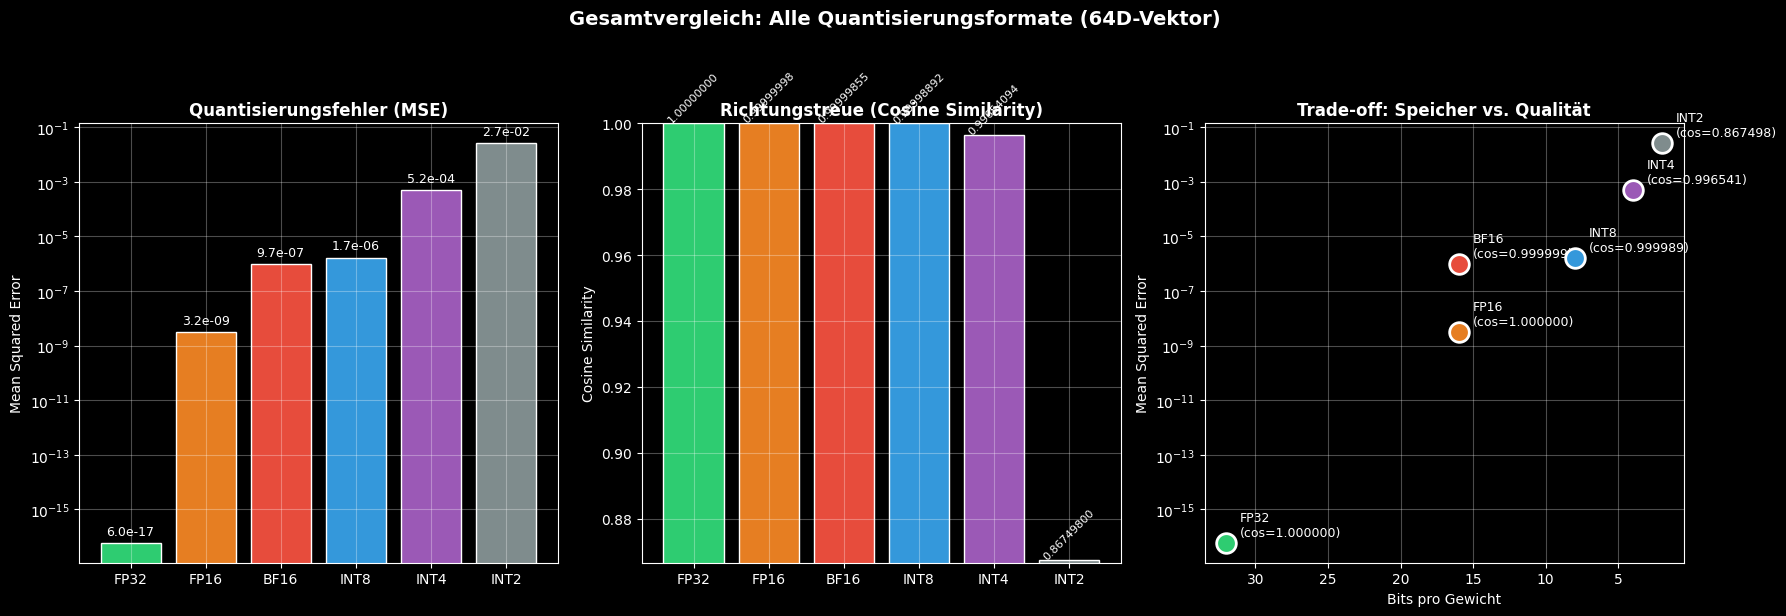

In [143]:
# ============================================================
# Gesamtvergleich: Alle Formate
# ============================================================

all_results = [
    ('FP32',  32, 4.0,   errors[0]),
    ('FP16',  16, 2.0,   errors[1]),
    ('BF16',  16, 2.0,   errors[2]),
    ('INT8',   8, 1.0,   int_errors[0]),
    ('INT4',   4, 0.5,   int_errors[1]),
    ('INT2',   2, 0.25,  int_errors[2]),
]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

names_all = [r[0] for r in all_results]
bits_all = [r[1] for r in all_results]
bytes_all = [r[2] for r in all_results]
mse_all = [r[3]['mse'] for r in all_results]
cos_all = [r[3]['cos_sim'] for r in all_results]
maxerr_all = [r[3]['max_error'] for r in all_results]

colors_all = ['#2ecc71', '#e67e22', '#e74c3c', '#3498db', '#9b59b6', '#7f8c8d']

# --- 1. MSE ---
ax1 = axes[0]
bars1 = ax1.bar(names_all, mse_all, color=colors_all, edgecolor='white')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Quantisierungsfehler (MSE)', fontweight='bold')
ax1.set_yscale('log')
for bar, val in zip(bars1, mse_all):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() * 2,
             f'{val:.1e}', ha='center', fontsize=9)

# --- 2. Cosine Similarity ---
ax2 = axes[1]
cos_loss = [1 - c for c in cos_all]  # Cosine Distance
bars2 = ax2.bar(names_all, cos_all, color=colors_all, edgecolor='white')
ax2.set_ylabel('Cosine Similarity')
ax2.set_title('Richtungstreue (Cosine Similarity)', fontweight='bold')
ax2.set_ylim(min(cos_all) * 0.999, 1.0001)
for bar, val in zip(bars2, cos_all):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0001,
             f'{val:.8f}', ha='center', fontsize=8, rotation=45)

# --- 3. Trade-off: Bits vs. Qualität ---
ax3 = axes[2]
for name, bits, mse, cos, color in zip(names_all, bits_all, mse_all, cos_all, colors_all):
    ax3.scatter(bits, mse, s=200, color=color, edgecolors='white', linewidth=2, zorder=3)
    ax3.annotate(f'{name}\n(cos={cos:.6f})', (bits, mse),
                 textcoords='offset points', xytext=(10, 5), fontsize=9)

ax3.set_xlabel('Bits pro Gewicht')
ax3.set_ylabel('Mean Squared Error')
ax3.set_title('Trade-off: Speicher vs. Qualit\u00e4t', fontweight='bold')
ax3.set_yscale('log')
ax3.invert_xaxis()  # Weniger Bits nach rechts

plt.suptitle('Gesamtvergleich: Alle Quantisierungsformate (64D-Vektor)',
             fontsize=14, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()

**Links:** Der MSE steigt exponentiell mit sinkender Bitzahl — INT2 ist um Größenordnungen schlechter als alle anderen Formate. **Mitte:** Die Cosine Similarity bleibt selbst bei INT4 über 0.99 — die semantische Richtung des Vektors ist bemerkenswert robust. Erst bei INT2 bricht die Similarity ein. **Rechts:** Der Trade-off zwischen Bits und Qualität: Zwischen 4 und 8 Bit liegt der "Sweet Spot" — deutliche Speichereinsparung bei akzeptablem Qualitätsverlust.

In [144]:
df_summary = pd.DataFrame({
    'Bits':            [bits for _, bits, _, _ in all_results],
    'Bytes/Gewicht':   [f'{bpw:.2f}' for _, _, bpw, _ in all_results],
    'MSE':             [f'{e["mse"]:.2e}' for _, _, _, e in all_results],
    'Max. Fehler':     [f'{e["max_error"]:.2e}' for _, _, _, e in all_results],
    'Cosine Sim.':     [f'{e["cos_sim"]:.10f}' for _, _, _, e in all_results],
    'Einsparung':      [f'{(1 - bpw/4.0)*100:.0f}%' for _, _, bpw, _ in all_results],
}, index=[name for name, _, _, _ in all_results])

display(df_summary)

,Bits,Bytes/Gewicht,MSE,Max. Fehler,Cosine Sim.,Einsparung
FP32,32,4.00,6.05e-17,2.13e-08,1.0000000000,0%
FP16,16,2.00,3.15e-09,2.35e-04,0.9999999792,50%
BF16,16,2.00,9.69e-07,3.67e-03,0.9999985470,50%
INT8,8,1.00,1.68e-06,2.29e-03,0.9999889247,75%
INT4,4,0.50,5.17e-04,4.15e-02,0.9965409380,88%
INT2,2,0.25,2.69e-02,2.93e-01,0.8674980044,94%


### Erkenntnisse

1. **FP32 → FP16:** 50% Einsparung bei minimalem Qualitätsverlust
2. **FP32 → INT8:** 75% Einsparung, Cosine Similarity > 0.999
3. **FP32 → INT4:** 87.5% Einsparung, messbarer aber akzeptabler Verlust
4. **BF16** hat mehr Fehler als FP16, dafür aber den gleichen Wertebereich wie FP32 — wichtig für Gradienten beim Training
5. **Block-Quantisierung** verbessert die Qualität gegenüber globaler Quantisierung deutlich
6. **INT2** ist in der Praxis kaum nutzbar — zu viel Information geht verloren

<a id="sec-summary"></a>

## 9. Zusammenfassung und Empfehlungen

### Was haben wir gelernt?

1. **Floating-Point-Formate** (FP64, FP32, FP16, BF16) unterscheiden sich in der Anzahl der **Mantissa-Bits**, die die Präzision bestimmen

2. **Integer-Quantisierung** (INT8, INT4) bildet Floats auf ganzzahlige Werte ab — mit einem **Scale Factor** pro Block

3. **Block-Quantisierung** (GGUF-Stil) verbessert die Qualität, indem jeder Block von 32 Werten seinen eigenen Scale Factor bekommt

4. Die **Cosine Similarity** bleibt selbst bei INT4 hoch — die **Richtung** des Vektors (= die semantische Bedeutung) ist robust gegenüber Quantisierung

### Praktische Empfehlungen

| Anwendungsfall | Empfohlenes Format | Begründung |
|----------------|-------------------|------------|
| Training | BF16 / FP16 | Halbiert den Speicher gegenüber FP32 und ermöglicht größere Batch-Sizes. BF16 vermeidet Overflow durch den großen Wertebereich. Integer-Quantisierung ist beim Training problematisch, weil Gradienten-Updates oft sehr kleine Werte erfordern, die bei INT8/INT4 auf Null gerundet würden. |
| Inference (GPU) | FP16 / INT8 | Schnell und gute Qualität — INT8 spart 75% Speicher bei Cosine Similarity > 0.999 |
| Inference (CPU/Edge) | Q4_K_M / Q5_K_M | Passt in weniger RAM; K-Quant nutzt Mixed Precision für bessere Qualität als Legacy-Quantisierung |
| Experimentieren | Q8_0 | Kaum Qualitätsverlust, gut zum Testen ob ein Modell grundsätzlich funktioniert |

### Weiterführend

- GGUF-Konverter: `quantization/gguf-converter/`
- LoRA-Erklärung: `languageModel/docs/LORA_EXPLAINED.md`